# Predcition of Hospital Admission Related to Infections

In this notebook, we develop a Cox proportional hazard regression model to predict the risk of hospital admission for common infections including urinary tract infection (urti), upper respiratory tract infection (URTI), lower respiratory tract infection (LRTI), sinusitis, otitis media or middle ear infection (ot media), and ear infection or otitis externa (ot externa).

In [1]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import os
import glob
import gzip
from matplotlib.ticker import PercentFormatter
from patsy import dmatrices
from lifelines import CoxPHFitter
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
import pickle
from sklearn.preprocessing import PolynomialFeatures
from lifelines.utils import k_fold_cross_validation
from lifelines.utils import concordance_index
from lifelines.calibration import survival_probability_calibration
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import brier_score_loss
from sklearn.calibration import CalibrationDisplay
from sklearn.preprocessing import OneHotEncoder
import io
import sys
from contextlib import redirect_stdout
# %matplotlib inline

In [2]:
#os.chdir("..")
current_working_dir = os.getcwd()
# print(current_working_dir)

# !python --version
# import sklearn
# print(sklearn.__version__)
# import lifelines
# print(lifelines.__version__)

In [3]:
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
print("No Warning Shown")

No Warning Shown


## 0- Functions

In [4]:
# def makeFilePath(pathFromWorkspace, fileName):
#     workingdir = "/workspace/" if (os.name != "nt") else ""
#     filepath = workingdir+pathFromWorkspace+fileName

#     return filepath

In [5]:
def create_histplot(title, df, ax):
    ax.hist(df, color = 'purple', edgecolor = 'black', bins=20)
    ax.set_title(title)
    ax.set_ylabel('Frequency')
    ax.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=0)

In [6]:
# def create_lineplot(data, var, title, legend_title, ax1):
def create_lineplot(data, var, title, ax1):
    a = data.groupby(['date', var]).size().reset_index()
    a.columns = ['date', var, 'Freq']
    a.Freq = a.Freq /1000
    sns.lineplot(x='date', y='Freq', 
            hue=var, 
            data=a,
            ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('Count in 1000 patients')
    ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=90)
#     ax1.legend(title=legend_title)
    ax1.grid()
    ax1.axvline(x="2020-01", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2020-04", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2021-04", color='black', ls='--', lw=1.5)

In [7]:
# function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [8]:
def ConvertColumns(InfectionKey, NumSets):
    for i in range(1, NumSets+1):        
        arrayKey1 = 'admitted_'+InfectionKey+'_date_'+str(i)
        #arrayKey2 = InfectionKey+'_date_'+str(i)
        data[arrayKey1] = data[arrayKey1].astype('datetime64[ns]')

## 1- Data Preparation

In [9]:
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation.csv.gz')
data.shape

(200000, 79)

In [10]:
data.describe(include='all')

,deregistered_date,died_date,bmi_date_measured,smoking_status_date,most_recent_unclear_smoking_cat_date,flu_vaccine_med,flu_vaccine_clinical,admitted_date,urti_date_1,urti_date_2,...,hemiplegia_comor,hiv_comor,metastatic_cancer_comor,mild_liver_comor,mod_severe_liver_comor,mod_severe_renal_comor,mi_comor,peptic_ulcer_comor,peripheral_vascular_comor,patient_id
count,10000,20000,150000,20000,20000,20000,20000,60000,20000,20000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,2.000000e+05
unique,1226,702,41,41,41,13,13,1227,1227,1227,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2022-01-07,2022-05-03,2019-05,2019-07,2021-10,2018-05,2018-05,2021-01-23,2020-04-22,2020-03-27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,25,182,3952,557,550,1750,1724,72,31,31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,9.989280e+05
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.300001,0.300001,0.300001,0.300001,0.300001,0.300001,0.300001,0.300001,0.300001,5.770010e+05
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.986452e+05
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.979700e+05
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.499005e+06


### 1-2- Additional variables
#### 1-2-1- Calculating CHarlson Comorbidity Index
Based on https://www.nature.com/articles/4500889.pdf?origin=ppub

In [11]:
data['CCI'] = np.nan
col0 = data.columns.get_loc('CCI')

col1 = data.columns.get_loc('cancer_comor')
col2 = data.columns.get_loc('cardiovascular_comor')
col3 = data.columns.get_loc('chronic_obstructive_pulmonary_comor') ##
col4 = data.columns.get_loc('heart_failure_comor') ##
col5 = data.columns.get_loc('connective_tissue_comor')
col6 = data.columns.get_loc('dementia_comor')
col7 = data.columns.get_loc('diabetes_comor')
col8 = data.columns.get_loc('diabetes_complications_comor')
col9 = data.columns.get_loc('hemiplegia_comor')
col10 = data.columns.get_loc('hiv_comor')
col11 = data.columns.get_loc('metastatic_cancer_comor')
col12 = data.columns.get_loc('mild_liver_comor')
col13 = data.columns.get_loc('mod_severe_liver_comor')
col14 = data.columns.get_loc('mod_severe_renal_comor')
col15 = data.columns.get_loc('mi_comor')
col16 = data.columns.get_loc('peptic_ulcer_comor')
col17 = data.columns.get_loc('peripheral_vascular_comor')

col18 = data.columns.get_loc('age')

In [13]:
for idx, x in enumerate(data['CCI']):
    n=0
    #comorbidity component
    if data.iat[idx, col15] == 1: # mi_comor
        n=n+1
    if data.iat[idx, col2] == 1: # cardiovascular_comor
        n=n+1 
    if data.iat[idx, col17] == 1: # peripheral_vascular_comor
        n=n+1 
    if data.iat[idx, col3] == 1: # chronic_obstructive_pulmonary_comor
        n=n+1
    # if data.iat[idx, col4] == 1: # heart_failure_comor############################
    #     n=n+1
    if data.iat[idx, col7] == 1: # diabetes_comor
        n=n+1
    if data.iat[idx, col6] == 1: # dementia_comor
        n=n+1
    if data.iat[idx, col16] == 1: # peptic_ulcer_comor
        n=n+1
    if data.iat[idx, col5] == 1: # connective_tissue_comor
        n=n+1
    if data.iat[idx, col12] == 1: # mild_liver_comor
        n=n+1
    
    if data.iat[idx, col9] == 1: # hemiplegia_comor
        n=n+2
    if data.iat[idx, col14] == 1: # mod_severe_renal_comor
        n=n+2
    if data.iat[idx, col8] == 1: # diabetes_complications_comor
        n=n+2
    if data.iat[idx, col1] == 1: # cancer_comor
        n=n+2
    #if data.iat[idx, col5] == 1: # Leukaemia#########################################
    #    n=n+2
    #if data.iat[idx, col12] == 1: # Lymphoma#########################################
    #    n=n+2

    if data.iat[idx, col13] == 1: # mod_severe_liver_comor
        n=n+3

    if data.iat[idx, col11] == 1: # metastatic_cancer_comor
        n=n+6
    if data.iat[idx, col10] == 1: # hiv_comor
        n=n+6

    # #age component
    # if data.iat[idx, col18] <= 40:
    #     n=n+0
    # if data.iat[idx, col18] > 40 and data.iat[idx, col18] <= 50:
    #     n=n+1
    # if data.iat[idx, col18] > 50 and data.iat[idx, col18] <= 60:
    #     n=n+2
    # if data.iat[idx, col18] > 60 and data.iat[idx, col18] <= 70:
    #     n=n+3
    # if data.iat[idx, col18] > 70:# and data.iat[idx, col18] <= 80:
    #     n=n+4
    
    data.iat[idx, col0]=n

data.CCI.value_counts()

0.0     37253
1.0     37075
2.0     32729
3.0     24895
4.0     14960
6.0     12191
7.0      9870
5.0      8351
8.0      8038
9.0      5721
10.0     3440
11.0     1893
12.0     1423
13.0      849
14.0      567
15.0      359
16.0      191
17.0      105
18.0       61
19.0       21
20.0        7
21.0        1
Name: CCI, dtype: int64

#### 1-2-2- Calculating all meds except abs

In [14]:
#generate meds_noabs in the one month before
data['meds_nonabs'] = data['all_meds'] - data['antibacterial_brit']

# assign zero for any row with negative values which could be the case because of using dummy data and/or the inconsistency of the two codelists of all_meds and antibacterial_brit
data['meds_nonabs'][data['meds_nonabs'] < 0] = 0

data['meds_nonabs'].value_counts()
# data[['all_meds_one_month', 'antibacterial_brit_one_month', 'meds_nonabs']]

0    133022
2     22130
3     18811
1     17640
4      7161
5      1160
6        74
7         2
Name: meds_nonabs, dtype: int64

### 1-3- Handling variables with missing values
#### 1-3-1- Drop variables with many missing values
We drop colmns with more than 50 percent missing values as they may not be usable in the prediction model, nor they can be imputed properly.

In [15]:
#dropping any variable with more than 50 percent missing values
perc = 50.0
data[['age', 'sex', 'CCI', 'bmi', 'antibacterial_brit', 'gp_count', 'imd', 'meds_nonabs', 'region']] = data[['age', 'sex', 'CCI', 'bmi', 'antibacterial_brit', 'gp_count', 'imd', 'meds_nonabs', 'region']].loc[:, data[['age', 'sex', 'CCI', 'bmi', 'antibacterial_brit', 'gp_count', 'imd', 'meds_nonabs', 'region']].isnull().mean() < perc]
data.shape

(200000, 81)

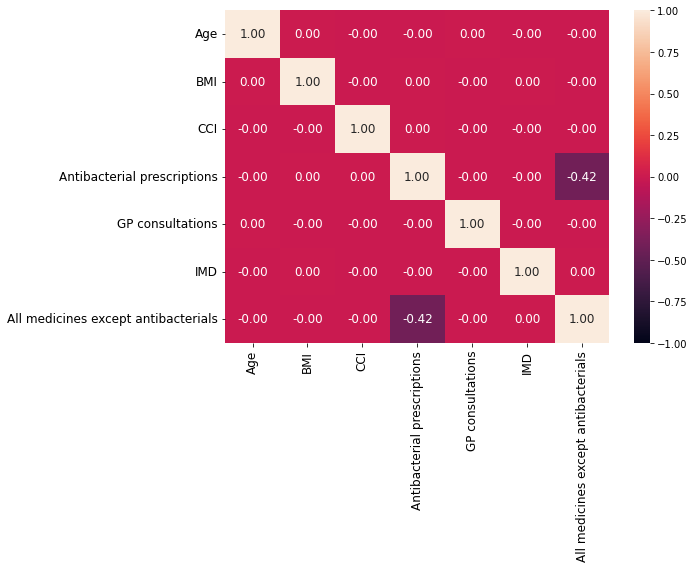

In [16]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data[['age', 'bmi', 'CCI', 'antibacterial_brit', 'gp_count', 'imd', 'meds_nonabs']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions', 'GP consultations' , 'IMD', 'All medicines except antibacterials'], rotation=90, fontsize=12)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions', 'GP consultations' , 'IMD', 'All medicines except antibacterials'], rotation=0, fontsize=12)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/corr_urti.jpg')
plt.show()

#### 1-3-2- Imputation of missing values
We impute variables with missing values that at most 50 pecent of their values are missing.

In [17]:
# prep before plot
data['age'][data['age'] < 0] = np.nan

## remove died cases
#data.died_date.value_counts()

# remove cases with bmi equal 0
data['bmi'][data['bmi'] <= 0] = 0

# remove cases with negative gp_count
data['gp_count'][data['gp_count'] < 0] = np.nan

# remove cases with negative antibacterial_brit
data['antibacterial_brit'][data['antibacterial_brit'] < 0] = np.nan

In [18]:
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data = data.replace({"sex": dict_sex})
data = data.replace({"smoking_status": dict_smoking})

In [19]:
if ('bmi' in data.columns) and (data['bmi'].isnull().sum() > 0):
    # # iterative imputation with sklearn package
    imputer = IterativeImputer(max_iter=10, random_state=0, missing_values=0)
    # imputer.fit(data[['age', 'sex', 'bmi']])
    imputer.fit(data[['age', 'sex', 'CCI', 'bmi']])# 'CCI']])
    # data['bmi_imp'] = np.nan
    # data['bmi_imp'] = np.round(imputer.transform(data[['age', 'sex', 'bmi']]))[:,2]
    data['bmi_imp'] = np.round(imputer.transform(data[['age', 'sex', 'CCI', 'bmi']]))[:,3]
elif ('bmi' in data.columns) and (data['bmi'].isnull().sum() == 0):
    data['bmi_imp'] = data['bmi']

# 
print(f'Count of missing values in variable bmi: {data.bmi.isnull().sum()}')
print(f'Mean of bmi values: {data.bmi.mean():.3f}')
print(f'Max of bmi values: {data.bmi.max():.3f}')
print(f'Min of bmi values: {data.bmi.min():.3f}')
print(f'Count of missing values in variable bmi after imputation: {data.bmi_imp.isnull().sum()}')
print(f'Mean of bmi values after imputation: {data.bmi_imp.mean():.3f}')
print(f'Max of bmi values after imputation: {data.bmi_imp.max():.3f}')
print(f'Min of bmi values after imputation: {data.bmi_imp.min():.3f}')

Count of missing values in variable bmi: 0
Mean of bmi values: 26.279
Max of bmi values: 77.867
Min of bmi values: 0.000
Count of missing values in variable bmi after imputation: 0
Mean of bmi values after imputation: 26.279
Max of bmi values after imputation: 77.867
Min of bmi values after imputation: 0.000


In [20]:
if ('imd' in data.columns) and (data['imd'].isnull().sum() > 0):
    data['imd'] = data['imd'].astype(str)
    # # iterative imputation with sklearn package
    imputer = IterativeImputer(max_iter=10, random_state=0, missing_values=0)
    imputer.fit(data[['age', 'sex', 'CCI', 'imd']])#'bmi_imp']])
    # data['imd_imp'] = np.nan
    data['imd_imp'] = np.round(imputer.transform(data[['age', 'sex', 'CCI', 'imd']]))[:,3]
    # data['imd_imp'] = data['imd_imp'].astype(str)
elif ('imd' in data.columns) and (data['imd'].isnull().sum() == 0):
    data['imd_imp'] = data['imd']
    # data['imd_imp'] = data['imd_imp'].astype(str)

print(f'Cound of missing values in variable imd: {data.imd.isnull().sum()}')
print(f'Count of categories of variable imd: \n{data.imd.value_counts()}')
print(f'\nCound of missing values in variable imd after imputation: {data.imd_imp.isnull().sum()}')
print(f'Count of categories of variable imd after imputation: \n{data.imd_imp.value_counts()}')

Cound of missing values in variable imd: 0
Count of categories of variable imd: 
2    38149
1    38134
4    38025
3    37967
5    37906
0     9819
Name: imd, dtype: int64

Cound of missing values in variable imd after imputation: 0
Count of categories of variable imd after imputation: 
2    38149
1    38134
4    38025
3    37967
5    37906
0     9819
Name: imd_imp, dtype: int64


In [21]:
if ('smoking_status' in data.columns) and (data['smoking_status'].isnull().sum() > 0):
    data['smoking_status'] = data['smoking_status'].astype(str)
    # data['smoking_status_imp'] = data['smoking_status'].replace(np.nan, 0)
    # # iterative imputation with sklearn package
    imputer = IterativeImputer(max_iter=10, random_state=0, missing_values=np.nan)
    imputer.fit(data[['age', 'sex', 'CCI', 'bmi_imp', 'smoking_status']])#'imd']]) # 'imd_imp'
    # data['smoking_status_imp'] = np.nan
    data['smoking_status_imp'] = np.round(imputer.transform(data[['age', 'sex', 'CCI', 'bmi_imp', 'smoking_status']]))[:,4]
    # data['smoking_status_imp'] = data['smoking_status_imp'].astype(str)
elif ('smoking_status' in data.columns) and (data['smoking_status'].isnull().sum() == 0):
    data['smoking_status_imp'] = data['smoking_status']
    # data['smoking_status_imp'] = data['smoking_status_imp'].astype(str)

print(f'Cound of missing values in variable smoking_status: {data.smoking_status.isnull().sum()}')
print(f'Count of categories of variable smoking_status: \n{data.smoking_status.value_counts()}')
print(f'\nCound of missing values in variable smoking_status after imputation: {data.smoking_status_imp.isnull().sum()}')
print(f'Count of categories of variable smoking_status after imputation: \n{data.smoking_status_imp.value_counts()}')

Cound of missing values in variable smoking_status: 0
Count of categories of variable smoking_status: 
nan    82975
1.0    77868
3.0    26044
2.0    13113
Name: smoking_status, dtype: int64

Cound of missing values in variable smoking_status after imputation: 0
Count of categories of variable smoking_status after imputation: 
2.0    96088
1.0    77868
3.0    26044
Name: smoking_status_imp, dtype: int64


In [22]:
if ('ethnicity' in data.columns) and (data['ethnicity'].isnull().sum() > 0):
    data['ethnicity'] = data['ethnicity'].astype(str)
    # data['ethnicity_imp'] = data['ethnicity'].replace(np.nan, 0)
    # # iterative imputation with sklearn package
    imputer = IterativeImputer(max_iter=10, random_state=0, missing_values=np.nan)
    imputer.fit(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd', 'ethnicity']])# 'smoking_status_imp']]) #'imd_imp'
    # data['ethnicity_imp'] = np.nan
    data['ethnicity_imp'] = np.round(imputer.transform(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd', 'ethnicity']]))[:,5] #'imd_imp'
    # data['ethnicity_imp'] = data['ethnicity_imp'].astype(str)
elif ('ethnicity' in data.columns) and (data['ethnicity'].isnull().sum() == 0):
    data['ethnicity_imp'] = data['ethnicity']
    # data['ethnicity_imp'] = data['ethnicity_imp'].astype(str)

print(f'Cound of missing values in variable ethnicity: {data.ethnicity.isnull().sum()}')
print(f'Count of categories of variable ethnicity: \n{data.ethnicity.value_counts()}')
print(f'\nCound of missing values in variable ethnicity after imputation: {data.ethnicity_imp.isnull().sum()}')
print(f'Count of categories of variable ethnicity after imputation: \n{data.ethnicity_imp.value_counts()}')

Cound of missing values in variable ethnicity: 0
Count of categories of variable ethnicity: 
1.0    119948
nan     50000
3.0     15028
5.0     15024
Name: ethnicity, dtype: int64

Cound of missing values in variable ethnicity after imputation: 0
Count of categories of variable ethnicity after imputation: 
1.0    119948
2.0     50000
3.0     15028
5.0     15024
Name: ethnicity_imp, dtype: int64


In [23]:
if ('gp_count' in data.columns) and (data['gp_count'].isnull().sum() > 0):
    # # iterative imputation with sklearn package
    # imputer = IterativeImputer(max_iter=10, random_state=0, missing_values=np.nan)
    # imputer.fit(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd', 'smoking_status_imp', 'gp_count']])# 'ethnicity_imp']]) # 'imd_imp'
    # # data['gp_count_imp'] = np.nan
    # data['gp_count_imp'] = np.round(imputer.transform(data[['age', 'sex', 'CCI', 'gp_count']]))[:,3] #'imd_imp'
    # drop gp_count value missing
    data['gp_count_imp'] = data['gp_count']
    data = data[data['gp_count_imp'].notna()]
elif ('gp_count' in data.columns) and (data['gp_count'].isnull().sum() == 0):
    data['gp_count_imp'] = data['gp_count']

print(f'Cound of missing values in variable gp_count: {data.gp_count.isnull().sum()}')
print(f'Mean of gp_count values: {data.gp_count.mean():.3f}')
print(f'\nCound of missing values in variable gp_count after imputation: {data.gp_count_imp.isnull().sum()}')
print(f'Mean of gp_count values after imputation: {data.gp_count_imp.mean():.3f}')

Cound of missing values in variable gp_count: 0
Mean of gp_count values: 3.350

Cound of missing values in variable gp_count after imputation: 0
Mean of gp_count values after imputation: 3.350


In [24]:
if ('antibacterial_brit' in data.columns) and (data['antibacterial_brit'].isnull().sum() > 0):
#     # # iterative imputation with sklearn package
#     imputer = IterativeImputer(max_iter=10, random_state=0, missing_values=np.nan)
#     imputer.fit(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd', 'smoking_status_imp', 'ethnicity_imp', 'antibacterial_brit']])# 'gp_count']]) #'imd_imp'
#     # data['antibacterial_brit_imp'] = np.nan
#     data['antibacterial_brit_imp'] = np.round(imputer.transform(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd', 'smoking_status_imp', 'ethnicity_imp', 'antibacterial_brit']]))[:,7] # 'imd_imp'
    # drop antibacterial_brit value missing
    data['antibacterial_brit_imp'] = data['antibacterial_brit']
    data = data[data['antibacterial_brit_imp'].notna()]
elif ('antibacterial_brit' in data.columns) and (data['antibacterial_brit'].isnull().sum() == 0):
    data['antibacterial_brit_imp'] = data['antibacterial_brit']

print(f'Cound of missing values in variable antibacterial_brit: {data.antibacterial_brit.isnull().sum()}')
print(f'Mean of antibacterial_brit values: {data.antibacterial_brit.mean():.3f}')
print(f'\nCound of missing values in variable antibacterial_brit after imputation: {data.antibacterial_brit_imp.isnull().sum()}')
print(f'Mean of antibacterial_brit values after imputation: {data.antibacterial_brit_imp.mean():.3f}')

Cound of missing values in variable antibacterial_brit: 0
Mean of antibacterial_brit values: 1.252

Cound of missing values in variable antibacterial_brit after imputation: 0
Mean of antibacterial_brit values after imputation: 1.252


In [25]:
if ('region' in data.columns) and (data['region'].isnull().sum() > 0):
#     # iterative imputation with sklearn package
#     imputer = IterativeImputer(max_iter=10, random_state=0, missing_values=np.nan)
#     imputer.fit(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd', 'ethnicity_imp', 'region']])
#     # data['region_imp'] = np.nan
#     data['region_imp'] = np.round(imputer.transform(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd', 'ethnicity_imp', 'region']]))[:,7] # 'imd_imp'
    # drop region value missing
    data['region_imp'] = data['region']
    data = data[data['region_imp'].notna()]
elif ('region' in data.columns) and (data['region'].isnull().sum() == 0):
    data['region_imp'] = data['region']

print(f'Cound of missing values in variable region: {data.region.isnull().sum()}')
print(f'Count of categories of variable region: \n{data.region.value_counts()}')
print(f'\nCound of missing values in variable region after imputation: {data.region_imp.isnull().sum()}')
print(f'Count of categories of variable region after imputation: \n{data.region_imp.value_counts()}')

Cound of missing values in variable region: 0
Count of categories of variable region: 
London                      39725
North West                  20091
East Midlands               19948
North East                  19938
East                        19872
South East                  19870
Yorkshire and The Humber    19841
South West                  19789
West Midlands               19715
Name: region, dtype: int64

Cound of missing values in variable region after imputation: 0
Count of categories of variable region after imputation: 
London                      39725
North West                  20091
East Midlands               19948
North East                  19938
East                        19872
South East                  19870
Yorkshire and The Humber    19841
South West                  19789
West Midlands               19715
Name: region_imp, dtype: int64


### 1-4- Translating states with dictionaries

In [26]:
# define dictionaries
dict_sex = {0: 'Female', 1: 'Male'}
# dict_bmi_imp_cat = {'Underweight': 'Underweight', 'Healthy weight': 'Healthy weight', 'Overweight': 'Overweight', 'Obese': 'Obese', 
#                 np.nan: 'Unknown'}
# dict_imd = {0: 'Unknown', 1: '1 (most deprived)', 2: '2', 3: '3', 4: '4', 5: '5 (least deprived)', np.nan: 'Unknown'}
# dict_ethnicity = {1: 'White', 2: 'Mixed', 3: 'Asian', 4: 'Black', 5: 'Other', 0: 'Unknown', np.nan: 'Unknown'}
dict_ethnicity_imp = {1: 'White', 2: 'Mixed', 3: 'Asian', 4: 'Black', 5: 'Other', 0: 'Unknown'}
# dict_smoking_imp = {1:'Smoker', 2:'Ex-smoker', 3:'Never smoked'}
dict_smoking_imp = {1:'Smoker', 2:'Ex-smoker', 3:'Never smoked', 0: 'Unknown'}
# dict_smoking = {'E': 'Ex-smoker', 'M': 'Unknown', 'S': 'Smoker', 'N': 'Never smoked'}
# dict_smoking_status= {'Smoker': 'Smoker', 'Never smoked': 'Never smoked', 'Ex-smoker': 'Ex-smoker', 'Unknown': 'Unknown', 
#                        np.nan: 'Unknown'}
# dict_gp_count_imp_cat = {'Few': 'Few', 'Some': 'Some', 'Many': 'Many', 'Too many': 'Too many', np.nan: 'Unknown'}
dict_flu = {0: 'No', 1: 'Yes'}

In [27]:
# reoplace values of dictionaries with existing ones
data = data.replace({"sex": dict_sex})
# data = data.replace({"bmi_imp_cat": dict_bmi_imp_cat})
# data = data.replace({"imd": dict_imd_imp})
data = data.replace({"ethnicity_imp": dict_ethnicity_imp})
data = data.replace({"smoking_status_imp": dict_smoking_imp})
# data = data.replace({"smoking_status": dict_smoking_status})
# data = data.replace({"gp_count_imp_cat": dict_gp_count_imp_cat})
data = data.replace({"flu_vaccine": dict_flu})

In [58]:
# categorising
data['bmi_imp_cat'] = pd.cut(data['bmi_imp'], right=False, bins=[0,18.5,25,30,10000000000], labels=['Underweight', 'Healthy weight', 'Overweight', 'Obese'])
data['gp_count_imp_cat'] = pd.cut(data['gp_count_imp'], right=False, bins=[0,3,8,10000000000], labels=['Few', 'Some', 'Many'])
data['CCI_cat'] = pd.cut(data['CCI'], right=False, bins=[0,1,3,5,8,10000000000], labels=['No', 'Low', 'Moderate', 'High', 'Very high'])
data['Age_cat'] = pd.cut(data['age'], right=False, bins=[0,18,60,10000000000], labels=['0-17 years', '18-59 years', '>59 years'])

data['antibacterial_brit_cat'] = pd.cut(data['antibacterial_brit_imp'], right=False, bins=[0,2,4,10000000000], labels=['Few', 'Some', 'Many'])
data['meds_nonabs_cat'] = pd.cut(data['meds_nonabs'], right=False, bins=[0,2,6,10000000000], labels=['Few', 'Some', 'Many'])

### 1-5- Polynomial featuring

In [59]:
X = data[['age']]
X.head()

,age
0,49
1,49
2,64
3,72
4,70


In [60]:
poly = PolynomialFeatures(degree=5, include_bias=False, interaction_only=False)
# poly.fit_transform(X)
poly_features = poly.fit_transform(X)
poly_features = pd.DataFrame(poly_features)
poly_features

,0,1,2,3,4
0,49.0,2401.0,117649.0,5764801.0,2.824752e+08
1,49.0,2401.0,117649.0,5764801.0,2.824752e+08
2,64.0,4096.0,262144.0,16777216.0,1.073742e+09
3,72.0,5184.0,373248.0,26873856.0,1.934918e+09
4,70.0,4900.0,343000.0,24010000.0,1.680700e+09
...,...,...,...,...,...
198784,67.0,4489.0,300763.0,20151121.0,1.350125e+09
198785,69.0,4761.0,328509.0,22667121.0,1.564031e+09
198786,74.0,5476.0,405224.0,29986576.0,2.219007e+09
198787,77.0,5929.0,456533.0,35153041.0,2.706784e+09


## 2- Plots
### 2-1- Continuous factors

In [61]:
# fig, axes = plt.subplots(3,2, 
#                         figsize=(15, 15)
#                         )
# create_histplot('BMI', data['bmi'], axes[0,0])
# create_histplot('Age', data['age'], axes[0,1])
# create_histplot('Count of GP consultation', data['gp_count'], axes[1,0])
# create_histplot('Practice', data['practice'], axes[1,1])
# create_histplot('CCI', data['CCI'], axes[2,0])
# fig.delaxes(ax=axes[2,1])

# fig.suptitle('Risk Factors', fontsize=16)
# fig.tight_layout(rect=[0, 0.03, 1, 0.98])
# #plt.tight_layout()
# plt.savefig('../output/hospitalisation_prediction_urti/risk_factors_cont.jpg')
# plt.show()

In [62]:
# p = sns.pairplot(data, vars=['age', 'bmi', 'gp_count', 'CCI'#, 'practice'
#                              ], 
#                 hue = 'admitted', # 'antibacterial_brit', 
# #                kind='reg', 
#                 #markers=["o", "s"], 
#                 diag_kind="kde",#"hist"
# #                plot_kws={#'line_kws':{'color':'red'}, 
#                 plot_kws={'alpha':0.3},
#                 height = 3)

# p.axes[0,2].set_xlim((0,20))
# p.axes[0,2].set_ylim((0,100))

# p.axes[1,1].set_xlim((0,75))
# p.axes[1,1].set_ylim((0,75))

# p.axes[2,0].set_xlim((0,100))
# p.axes[2,0].set_ylim((0,20))

# p.axes[0,3].set_xlim((0,20))
# p.axes[3,0].set_ylim((0,20))

# plt.suptitle('Pairplot of continuous factors', fontsize=16, y=1.05)
# plt.savefig('../output/hospitalisation_prediction_urti/risk_factors_cont_pairplot.jpg')
# plt.show()

### 2-2- Categorical factors

In [63]:
# fig, axes = plt.subplots(7,2,
#                         figsize=(15, 10)
#                         )
# create_lineplot(data, 'sex', 'Sex', 'Sex', axes[0,0])
# create_lineplot(data, 'age_cat', 'Age category', 'Age category', axes[0,1])
# create_lineplot(data, 'imd_imp', 'IMD', 'IMD', axes[1,0])
# create_lineplot(data, 'ethnicity_imp', 'Ethnicity', 'Ethnicity', axes[1,1])
# create_lineplot(data, 'smoking_status_imp', 'Smoking status', 'Smoking status', axes[2,0])
# create_lineplot(data, 'bmi_imp_cat', 'BMI', 'BMI', axes[2,1])
# create_lineplot(data, 'CCI_cat', 'CCI', 'CCI', axes[1,0])
# create_lineplot(data, 'gp_count_imp_cat', 'GP consultation', 'GP consultation', axes[3,1])
# create_lineplot(data, 'region', 'Region', 'Region', axes[4,0])
# create_lineplot(data, 'flu_vaccine', 'Flu vaccine', 'Flu vaccine', axes[4,1])
# create_lineplot(data, 'antibacterial_brit_imp', 'Antibacterial prescriptions', 'Antibacterial prescriptions', axes[5,0])
# create_lineplot(data, 'msoa', 'msoa', 'MSOA', axes[5,1])
# create_lineplot(data, 'meds_nonabs', 'Medicines excpet antibacterials', 'Medicines excpet antibacterials', axes[6,0])
# fig.delaxes(ax=axes[6,1])

# fig.suptitle('Risk Factors', fontsize=16)
# fig.tight_layout(rect=[0, 0.03, 1, 0.98])
# #plt.tight_layout()
# plt.savefig('../output/hospitalisation_prediction_urti/risk_factors_cat.jpg')
# plt.show()

## 3- Data preparation
This includes data type conversion and exclusion of cases that are not considered in the infection-related hospital admission, i.e. those who were diagnosed with Covid19 three months (=90 days) before and one month (=30 days) after hospital admission.

### 3-1- URTI

#### URTI-1

In [64]:
data_urti_1 = data[['Age_cat', 'msoa', #'date',
                    'age', 'age_cat', 'sex', 'bmi_imp', 'bmi_imp_cat', 'gp_count', 'gp_count_imp_cat', 'gp_count_imp', 'flu_vaccine', 
                    'region_imp', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp', 'ethnicity_imp', 'antibacterial_brit_imp', 'antibacterial_brit_cat',
                    'hx_hosp', 'CCI_cat', 'CCI', 'meds_nonabs', 'meds_nonabs_cat',  #'season', 
                    'died_date', 'deregistered_date', 'gp_cons_urti_1', 'gp_cons_urti_ab_1',
                    'urti_date_1', 'incdt_urti_date_1', 'admitted_urti_date_1', 'sgss_gp_cov_urti_date_1']]

data_urti_1 = data_urti_1[data_urti_1['urti_date_1'].notnull()]

data_urti_1.shape

(19888, 31)

In [65]:
# exclusion of covid positive 90 days before and 30 days after dx with urti_1
data_urti_1 = data_urti_1[data_urti_1['sgss_gp_cov_urti_date_1'] == 0]
data_urti_1.shape

(17926, 31)

In [66]:
data_urti_1.columns

Index(['Age_cat', 'msoa', 'age', 'age_cat', 'sex', 'bmi_imp', 'bmi_imp_cat',
       'gp_count', 'gp_count_imp_cat', 'gp_count_imp', 'flu_vaccine',
       'region_imp', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp',
       'ethnicity_imp', 'antibacterial_brit_imp', 'antibacterial_brit_cat',
       'hx_hosp', 'CCI_cat', 'CCI', 'meds_nonabs', 'meds_nonabs_cat',
       'died_date', 'deregistered_date', 'gp_cons_urti_1', 'gp_cons_urti_ab_1',
       'urti_date_1', 'incdt_urti_date_1', 'admitted_urti_date_1',
       'sgss_gp_cov_urti_date_1'],
      dtype='object')

In [67]:
# drop rows with no gp_cons_urti_1 records
data_urti_1 = data_urti_1.dropna(subset=['gp_cons_urti_1'])
data_urti_1.shape

(1752, 31)

#### URTI-2

In [68]:
data_urti_2 = data[['Age_cat', 'msoa', #'date',
                    'age', 'age_cat', 'sex', 'bmi_imp', 'bmi_imp_cat', 'gp_count', 'gp_count_imp_cat', 'gp_count_imp', 'flu_vaccine', 
                    'region_imp', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp', 'ethnicity_imp', 'antibacterial_brit_imp', 'antibacterial_brit_cat',
                    'hx_hosp', 'CCI_cat', 'CCI', 'meds_nonabs', 'meds_nonabs_cat',  #'season', 
                    'died_date', 'deregistered_date', 'gp_cons_urti_2', 'gp_cons_urti_ab_2',
                    'urti_date_2', 'incdt_urti_date_2', 'admitted_urti_date_2', 'sgss_gp_cov_urti_date_2']]

data_urti_2 = data_urti_2[data_urti_2['urti_date_2'].notnull()]

data_urti_2.shape

(19876, 31)

In [69]:
data_urti_1.urti_date_1.value_counts()

2022-04-16    7
2019-03-18    6
2019-01-28    6
2020-06-07    6
2020-11-24    6
             ..
2022-05-01    1
2021-06-25    1
2020-01-19    1
2019-07-05    1
2021-10-28    1
Name: urti_date_1, Length: 925, dtype: int64

In [70]:
data_urti_2.urti_date_2.value_counts()

2020-03-27    31
2019-03-23    29
2020-11-02    28
2021-10-31    28
2020-09-25    28
              ..
2019-04-03     7
2020-12-09     7
2020-12-05     6
2021-07-21     6
2022-03-30     6
Name: urti_date_2, Length: 1227, dtype: int64

In [71]:
# exclusion of covid positive 90 days before and 30 days after dx with urti_2
data_urti_2 = data_urti_2[data_urti_2['sgss_gp_cov_urti_date_2'] == 0]
data_urti_2.shape

(17946, 31)

In [72]:
data_urti_2.columns

Index(['Age_cat', 'msoa', 'age', 'age_cat', 'sex', 'bmi_imp', 'bmi_imp_cat',
       'gp_count', 'gp_count_imp_cat', 'gp_count_imp', 'flu_vaccine',
       'region_imp', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp',
       'ethnicity_imp', 'antibacterial_brit_imp', 'antibacterial_brit_cat',
       'hx_hosp', 'CCI_cat', 'CCI', 'meds_nonabs', 'meds_nonabs_cat',
       'died_date', 'deregistered_date', 'gp_cons_urti_2', 'gp_cons_urti_ab_2',
       'urti_date_2', 'incdt_urti_date_2', 'admitted_urti_date_2',
       'sgss_gp_cov_urti_date_2'],
      dtype='object')

In [73]:
# drop rows with no gp_cons_urti_2 records
data_urti_2 = data_urti_2.dropna(subset=['gp_cons_urti_2'])
data_urti_2.shape

(1736, 31)

#### URTI_3

In [74]:
data_urti_3 = data[['Age_cat', 'msoa', #'date',
                    'age', 'age_cat', 'sex', 'bmi_imp', 'bmi_imp_cat', 'gp_count', 'gp_count_imp_cat', 'gp_count_imp', 'flu_vaccine', 
                    'region_imp', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp', 'ethnicity_imp', 'antibacterial_brit_imp', 'antibacterial_brit_cat',
                    'hx_hosp', 'CCI_cat', 'CCI', 'meds_nonabs', 'meds_nonabs_cat',  #'season', 
                    'died_date', 'deregistered_date', 'gp_cons_urti_3', 'gp_cons_urti_ab_3',
                    'urti_date_3', 'incdt_urti_date_3', 'admitted_urti_date_3', 'sgss_gp_cov_urti_date_3']]

data_urti_3 = data_urti_3[data_urti_3['urti_date_3'].notnull()]

data_urti_3.shape

(19881, 31)

In [75]:
# exclusion of covid positive 90 days before and 30 days after dx with urti_3
data_urti_3 = data_urti_3[data_urti_3['sgss_gp_cov_urti_date_3'] == 0]
data_urti_3.shape

(17968, 31)

In [76]:
data_urti_3.columns

Index(['Age_cat', 'msoa', 'age', 'age_cat', 'sex', 'bmi_imp', 'bmi_imp_cat',
       'gp_count', 'gp_count_imp_cat', 'gp_count_imp', 'flu_vaccine',
       'region_imp', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp',
       'ethnicity_imp', 'antibacterial_brit_imp', 'antibacterial_brit_cat',
       'hx_hosp', 'CCI_cat', 'CCI', 'meds_nonabs', 'meds_nonabs_cat',
       'died_date', 'deregistered_date', 'gp_cons_urti_3', 'gp_cons_urti_ab_3',
       'urti_date_3', 'incdt_urti_date_3', 'admitted_urti_date_3',
       'sgss_gp_cov_urti_date_3'],
      dtype='object')

In [77]:
# drop rows with no gp_cons_urti_3 records
data_urti_3 = data_urti_3.dropna(subset=['gp_cons_urti_3'])
data_urti_3.shape

(1869, 31)

#### URTI_4

In [78]:
data_urti_4 = data[['Age_cat', 'msoa', #'date',
                    'age', 'age_cat', 'sex', 'bmi_imp', 'bmi_imp_cat', 'gp_count', 'gp_count_imp_cat', 'gp_count_imp', 'flu_vaccine', 
                    'region_imp', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp', 'ethnicity_imp', 'antibacterial_brit_imp', 'antibacterial_brit_cat',
                    'hx_hosp', 'CCI_cat', 'CCI', 'meds_nonabs', 'meds_nonabs_cat',  #'season', 
                    'died_date', 'deregistered_date', 'gp_cons_urti_4', 'gp_cons_urti_ab_4',
                    'urti_date_4', 'incdt_urti_date_4', 'admitted_urti_date_4', 'sgss_gp_cov_urti_date_4']]

data_urti_4 = data_urti_4[data_urti_4['urti_date_4'].notnull()]

data_urti_4.shape

(19873, 31)

In [79]:
# exclusion of covid positive 90 days before and 30 days after dx with urti_4
data_urti_4 = data_urti_4[data_urti_4['sgss_gp_cov_urti_date_4'] == 0]
data_urti_4.shape

(17948, 31)

In [80]:
data_urti_4.columns

Index(['Age_cat', 'msoa', 'age', 'age_cat', 'sex', 'bmi_imp', 'bmi_imp_cat',
       'gp_count', 'gp_count_imp_cat', 'gp_count_imp', 'flu_vaccine',
       'region_imp', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp',
       'ethnicity_imp', 'antibacterial_brit_imp', 'antibacterial_brit_cat',
       'hx_hosp', 'CCI_cat', 'CCI', 'meds_nonabs', 'meds_nonabs_cat',
       'died_date', 'deregistered_date', 'gp_cons_urti_4', 'gp_cons_urti_ab_4',
       'urti_date_4', 'incdt_urti_date_4', 'admitted_urti_date_4',
       'sgss_gp_cov_urti_date_4'],
      dtype='object')

In [81]:
data_urti_4.shape

(17948, 31)

In [82]:
# data_urti_4.gp_cons_urti_4.value_counts()#isnull().sum()
data_urti_4.gp_cons_urti_4.isnull().sum()

16212

In [83]:
# drop rows with no gp_cons_urti_4 records
data_urti_4 = data_urti_4.dropna(subset=['gp_cons_urti_4'])
data_urti_4.shape

(1736, 31)

#### Combining URTI_1, URTI_2, URTI_3, and URTI_4

In [84]:
data_urti_1.rename(columns={'urti_date_1': 'urti_date',
                           'gp_cons_urti_1': 'gp_cons_urti', 'gp_cons_urti_ab_1': 'gp_cons_urti_ab',
                           'incdt_urti_date_1': 'incdt_urti_date', #'prevl_urti_date_1': 'prevl_urti_date',
                           'admitted_urti_date_1': 'admitted_urti_date',
                           'sgss_gp_cov_urti_date_1': 'sgss_gp_cov_urti_date'},
                inplace=True)
data_urti_2.rename(columns={'urti_date_2': 'urti_date',
                           'gp_cons_urti_2': 'gp_cons_urti', 'gp_cons_urti_ab_2': 'gp_cons_urti_ab',
                           'incdt_urti_date_2': 'incdt_urti_date', #'prevl_urti_date_2': 'prevl_urti_date', 
                           'admitted_urti_date_2': 'admitted_urti_date',
                           'sgss_gp_cov_urti_date_2': 'sgss_gp_cov_urti_date'},
                inplace=True)
data_urti_3.rename(columns={'urti_date_3': 'urti_date',
                           'gp_cons_urti_3': 'gp_cons_urti', 'gp_cons_urti_ab_3': 'gp_cons_urti_ab',
                           'incdt_urti_date_3': 'incdt_urti_date', #'prevl_urti_date_3': 'prevl_urti_date', 
                           'admitted_urti_date_3': 'admitted_urti_date',
                           'sgss_gp_cov_urti_date_3': 'sgss_gp_cov_urti_date'},
                 inplace=True)
data_urti_4.rename(columns={'urti_date_4': 'urti_date', 
                           'gp_cons_urti_4': 'gp_cons_urti', 'gp_cons_urti_ab_4': 'gp_cons_urti_ab',
                           'incdt_urti_date_4': 'incdt_urti_date', #'prevl_urti_date_4': 'prevl_urti_date',
                           'admitted_urti_date_4': 'admitted_urti_date',
                           'sgss_gp_cov_urti_date_4': 'sgss_gp_cov_urti_date'}, 
                 inplace=True)

data_urti = pd.concat([data_urti_1, data_urti_2, data_urti_3, data_urti_4])
data_urti.reset_index(inplace=True, drop=True)
data_urti.shape

(7093, 31)

In [85]:
data_urti_4.columns

Index(['Age_cat', 'msoa', 'age', 'age_cat', 'sex', 'bmi_imp', 'bmi_imp_cat',
       'gp_count', 'gp_count_imp_cat', 'gp_count_imp', 'flu_vaccine',
       'region_imp', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp',
       'ethnicity_imp', 'antibacterial_brit_imp', 'antibacterial_brit_cat',
       'hx_hosp', 'CCI_cat', 'CCI', 'meds_nonabs', 'meds_nonabs_cat',
       'died_date', 'deregistered_date', 'gp_cons_urti', 'gp_cons_urti_ab',
       'urti_date', 'incdt_urti_date', 'admitted_urti_date',
       'sgss_gp_cov_urti_date'],
      dtype='object')

In [86]:
data_urti['urti_date'] = data_urti['urti_date'].astype('datetime64[ns]')
data_urti['gp_cons_urti'] = data_urti['gp_cons_urti'].astype('datetime64[ns]')
data_urti['admitted_urti_date'] = data_urti['admitted_urti_date'].astype('datetime64[ns]')
data_urti.died_date = data_urti.died_date.astype('datetime64[ns]')
data_urti.deregistered_date = data_urti.deregistered_date.astype('datetime64[ns]')
data_urti.shape

(7093, 31)

In [87]:
#add a variable called date using gp consultation dates
data_urti['date'] = data_urti['gp_cons_urti']
data_urti['date'] = data_urti['date'].dt.strftime('%Y-%m')

In [88]:
#add a variable called season based on the month of urti records
data_urti['season'] = np.nan
data_urti['date_month'] = pd.DatetimeIndex(data_urti['date']).month

conditions = [
    (data_urti['date_month'] >= 3) & (data_urti['date_month'] <= 5),
    (data_urti['date_month'] >= 6) & (data_urti['date_month'] <= 8),
    (data_urti['date_month'] >= 9) & (data_urti['date_month'] <= 11),]
choices = ['Spring', 'Summer', 'Autumn']
data_urti['season'] = np.select(conditions, choices, default='Winter')

data_urti['season'].value_counts()

Spring    2053
Winter    1879
Autumn    1594
Summer    1567
Name: season, dtype: int64

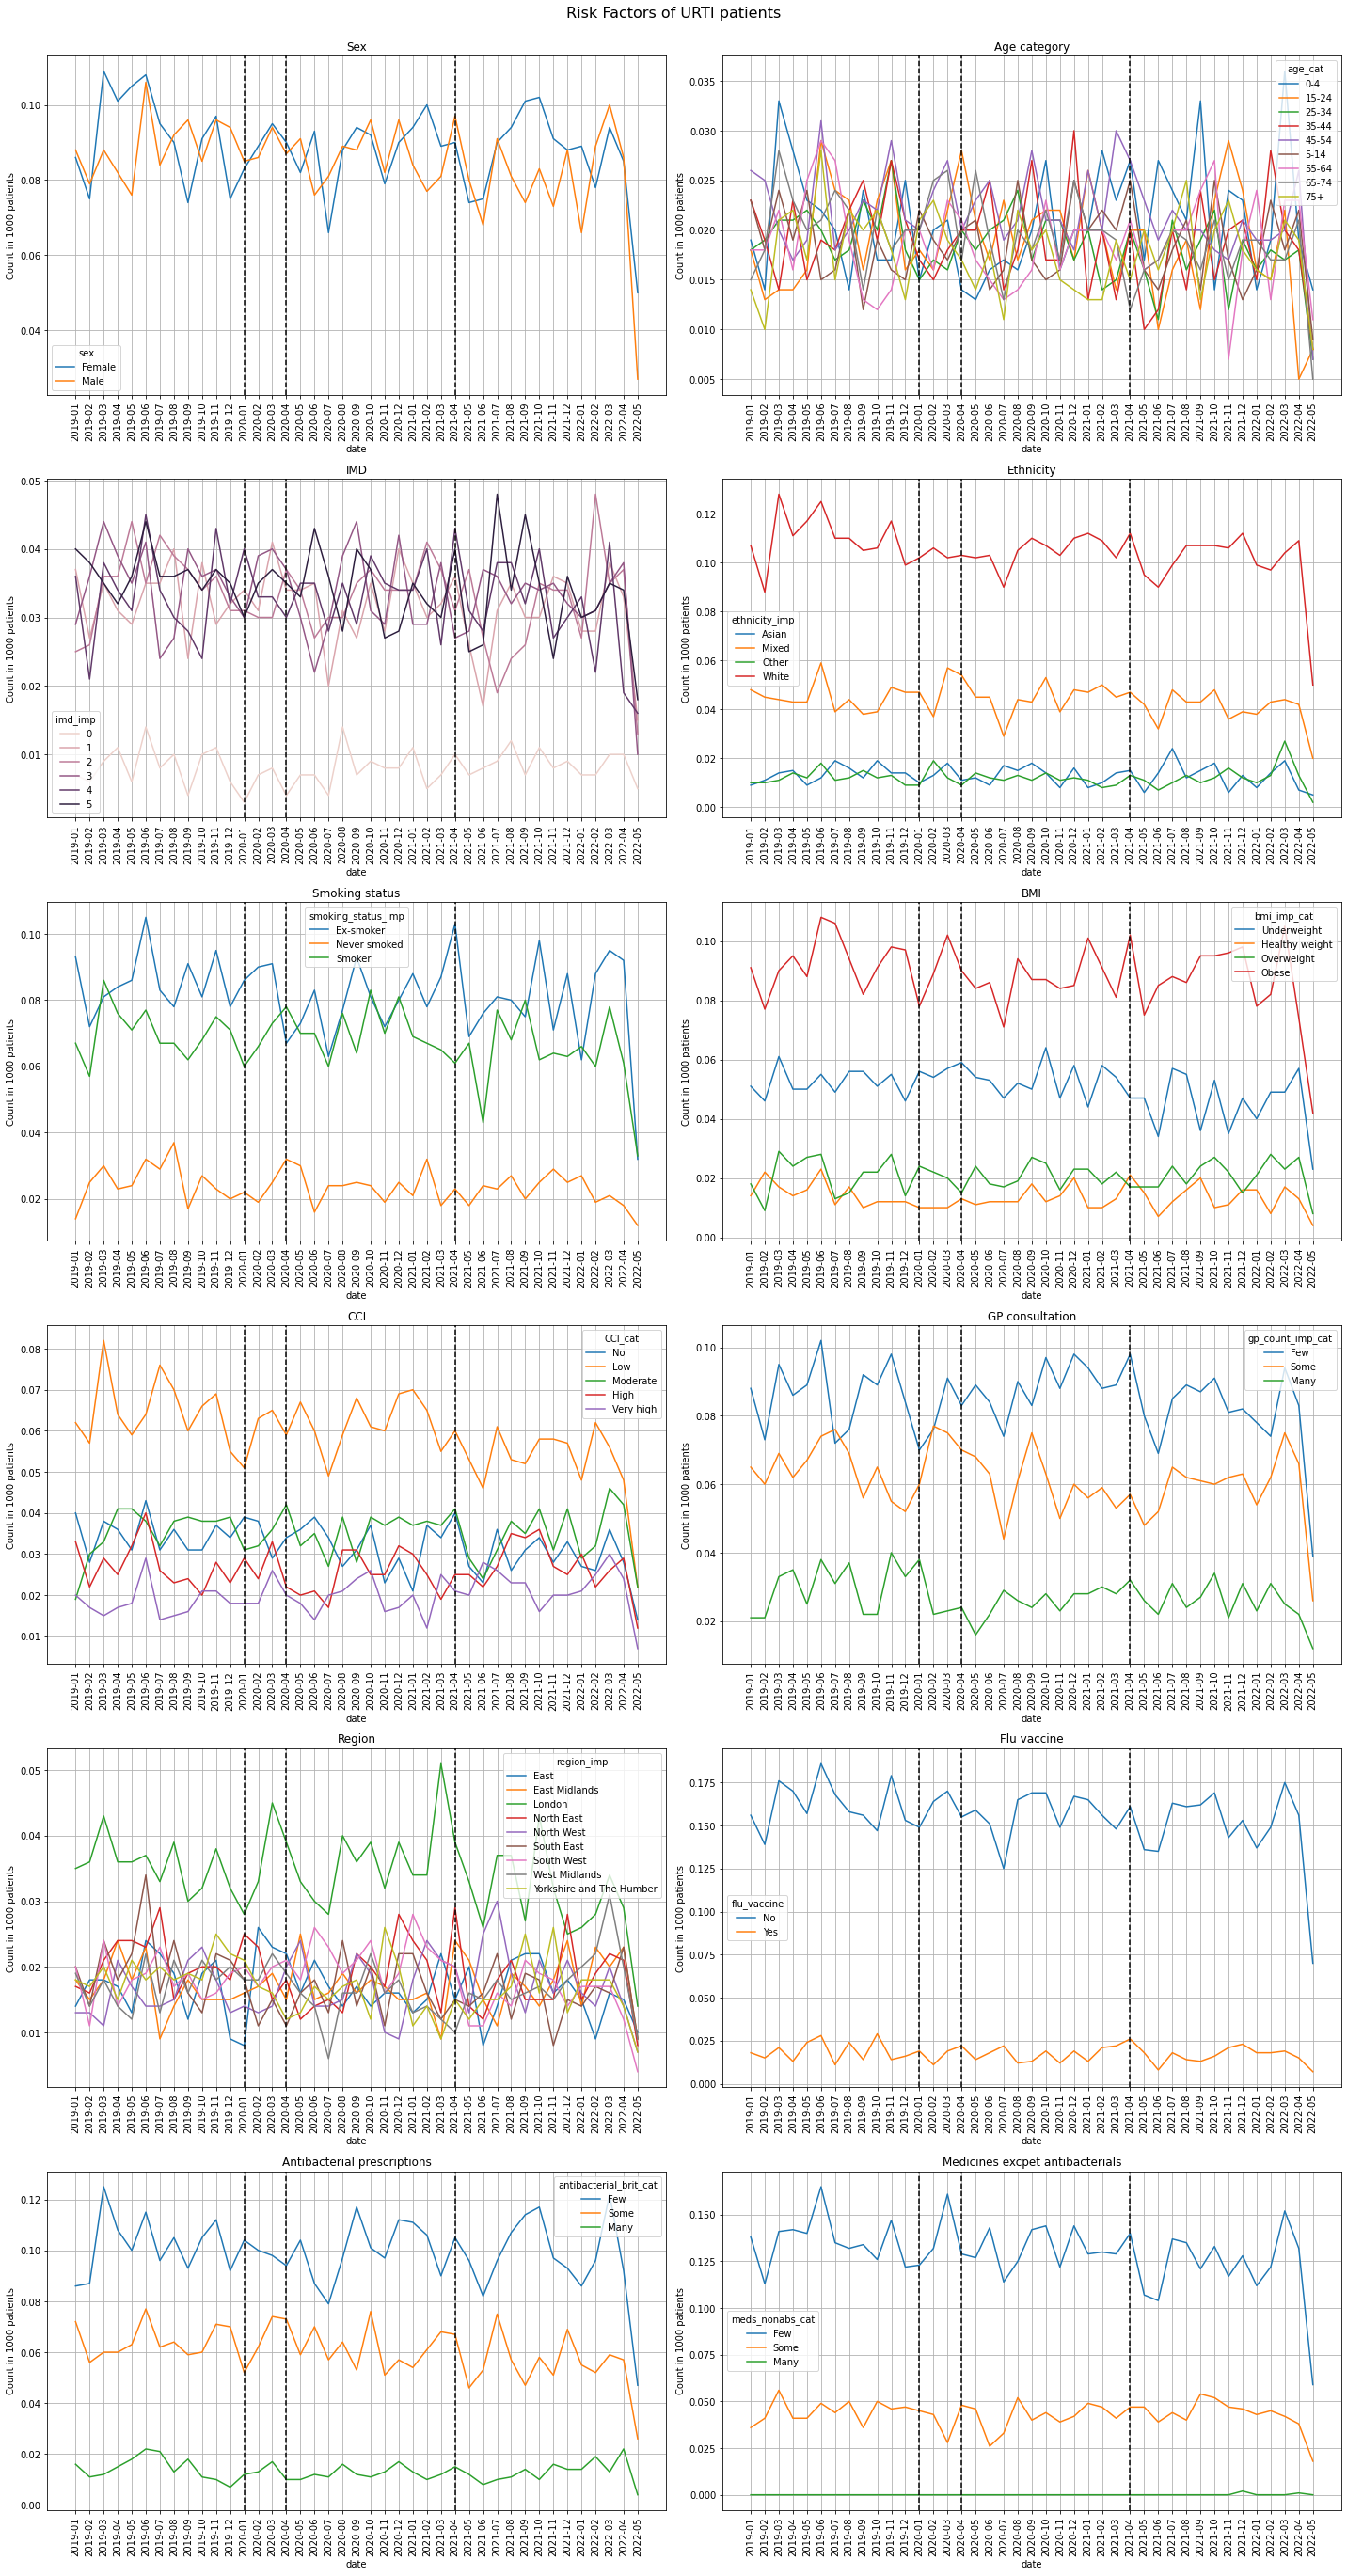

In [89]:
fig, axes = plt.subplots(6,2,
                        figsize=(20, 40)
                        )
create_lineplot(data_urti, 'sex', 'Sex', axes[0,0])
create_lineplot(data_urti, 'age_cat', 'Age category', axes[0,1])
create_lineplot(data_urti, 'imd_imp', 'IMD', axes[1,0])
create_lineplot(data_urti, 'ethnicity_imp', 'Ethnicity', axes[1,1])
create_lineplot(data_urti, 'smoking_status_imp', 'Smoking status', axes[2,0])
create_lineplot(data_urti, 'bmi_imp_cat', 'BMI', axes[2,1])
create_lineplot(data_urti, 'CCI_cat', 'CCI', axes[3,0])
create_lineplot(data_urti, 'gp_count_imp_cat', 'GP consultation', axes[3,1])
create_lineplot(data_urti, 'region_imp', 'Region', axes[4,0])
create_lineplot(data_urti, 'flu_vaccine', 'Flu vaccine', axes[4,1])
create_lineplot(data_urti, 'antibacterial_brit_cat', 'Antibacterial prescriptions', axes[5,0])
create_lineplot(data_urti, 'meds_nonabs_cat', 'Medicines excpet antibacterials', axes[5,1])
# fig.delaxes(ax=axes[6,1])

fig.suptitle('Risk Factors of URTI patients', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
#plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/risk_factors_cat_urti.jpg')
plt.show()

#### Adding event and duration columns

In [90]:
#scenario 1
#not hosped (nothing happened)
#data_urti = data_urti[data_urti['admitted_urti_date'].notnull()]
data_urti.loc[data_urti['admitted_urti_date'].isnull(), 'event_urti_admitted'] = 0
data_urti['event_urti_admitted'].value_counts()

0.0    4996
Name: event_urti_admitted, dtype: int64

In [91]:
#scenario 2 
# become a case (uncensoring)
#calculating days between infection gp consultation and hosp
# data_urti['delta_urti_admitted'] = (data_urti['admitted_urti_date'] - data_urti['urti_date']).dt.days
data_urti['delta_urti_admitted'] = (data_urti['admitted_urti_date'] - data_urti['gp_cons_urti']).dt.days
data_urti.loc[((data_urti['delta_urti_admitted'] >= 0) & (data_urti['delta_urti_admitted'] <= 30)), 'event_urti_admitted'] = 1
data_urti['event_urti_admitted'].value_counts()

0.0    4996
1.0      46
Name: event_urti_admitted, dtype: int64

In [92]:
#scenario 2
#drop whoever was admitted before urti consultation, i.e. negative value for delta_urti_admitted
data_urti = data_urti[~(data_urti['delta_urti_admitted'] < 0)]
data_urti['delta_urti_admitted'].value_counts()

91.0      5
61.0      5
328.0     5
516.0     5
109.0     5
         ..
86.0      1
296.0     1
333.0     1
1180.0    1
384.0     1
Name: delta_urti_admitted, Length: 664, dtype: int64

In [93]:
# data_urti['event_urti_admitted'].value_counts()
data_urti['event_urti_admitted'].isnull().sum()

1042

In [94]:
#scenario 3
#censor died patients
data_urti['delta_admitted_died'] = (data_urti['died_date'] - data_urti['admitted_urti_date']).dt.days
data_urti.loc[data_urti['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
# data_urti.loc[data_urti['delta_admitted_died'] >= 0, 'event_urti_admitted'] = 0
data_urti.loc[((data_urti['delta_admitted_died'] >= 0) & (data_urti['delta_admitted_died'] <= 30)), 'event_urti_admitted'] = 0
data_urti['event_urti_admitted'].value_counts()

0.0    5000
1.0      46
Name: event_urti_admitted, dtype: int64

In [95]:
#scenario 3
#censor deregistered patients
data_urti['delta_admitted_deregistered'] = (data_urti['deregistered_date'] - data_urti['admitted_urti_date']).dt.days
data_urti.loc[data_urti['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
# data_urti.loc[data_urti['delta_admitted_deregistered'] >= 0, 'event_urti_admitted'] = 0
data_urti.loc[((data_urti['delta_admitted_deregistered'] > 0) & (data_urti['delta_admitted_deregistered'] <= 30)), 'event_urti_admitted'] = 0
data_urti['event_urti_admitted'].value_counts()

0.0    5004
1.0      46
Name: event_urti_admitted, dtype: int64

In [96]:
#agg scenario 3s
data_urti['delta_admitted_died_deregistered'] = data_urti['delta_admitted_deregistered'].combine_first(data_urti['delta_admitted_died'])
data_urti.loc[data_urti['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN
data_urti['delta_admitted_died_deregistered'].isnull().sum()#.value_counts()

5969

In [97]:
data_urti['delta_admitted_died_deregistered'].value_counts()

327.0    3
3.0      2
254.0    2
2.0      2
189.0    2
        ..
539.0    1
44.0     1
298.0    1
260.0    1
192.0    1
Name: delta_admitted_died_deregistered, Length: 109, dtype: int64

In [98]:
#censor patients that had a history of hospital admission
# data_urti.loc[data_urti['hx_hosp'] == 1, 'event_urti_admitted'] = 0

In [99]:
#scenario 1
#any other patients (nothing happened)
data_urti['event_urti_admitted'] = data_urti['event_urti_admitted'].replace(np.NaN, 0)
data_urti['event_urti_admitted'].value_counts()

0.0    6038
1.0      46
Name: event_urti_admitted, dtype: int64

In [100]:
#assign values for duration column
data_urti['duration_urti_admitted'] = data_urti['delta_urti_admitted'].combine_first(data_urti['delta_admitted_died_deregistered'])
data_urti['duration_urti_admitted'] = data_urti['duration_urti_admitted'].replace(np.NaN, 30)
data_urti.loc[(data_urti['duration_urti_admitted'] > 30), 'duration_urti_admitted'] = 30
data_urti['duration_urti_admitted'].value_counts()

30.0    6039
9.0        4
2.0        3
28.0       3
20.0       3
4.0        3
26.0       3
13.0       2
6.0        2
7.0        2
19.0       2
23.0       2
25.0       2
27.0       2
29.0       2
18.0       1
0.0        1
10.0       1
17.0       1
12.0       1
11.0       1
24.0       1
5.0        1
21.0       1
16.0       1
Name: duration_urti_admitted, dtype: int64

In [101]:
# give value 1 to event_urti_admitted if duration_urti_admitted is greater or equal to 0 and less than 30
data_urti.loc[((data_urti['duration_urti_admitted'] >= 0) & (data_urti['duration_urti_admitted'] < 30)), 'event_urti_admitted'] = 1
data_urti['event_urti_admitted'].value_counts()

0.0    6038
1.0      46
Name: event_urti_admitted, dtype: int64

In [102]:
#drop any rows with value 0 in duration column
data_urti = data_urti[~(data_urti['duration_urti_admitted'] == 0)]

In [103]:
data_urti[data_urti['duration_urti_admitted']==0][['delta_urti_admitted', 'urti_date', 'gp_cons_urti', 'admitted_urti_date', 'delta_urti_admitted', 'delta_admitted_died_deregistered', 'event_urti_admitted', 'duration_urti_admitted']]

,delta_urti_admitted,urti_date,gp_cons_urti,admitted_urti_date,delta_urti_admitted,delta_admitted_died_deregistered,event_urti_admitted,duration_urti_admitted


In [104]:
#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_urti.loc[((data_urti['delta_urti_admitted'] > 0) & (data_urti['delta_urti_admitted'] < 30)), 'event_urti_admitted'] = 1

In [105]:
# data_urti['duration_urti_admitted'].value_counts()

In [106]:
# data_urti.loc[151:200, ['event_urti_admitted', 'duration_urti_admitted']]
# data_urti.loc[201:250, ['event_urti_admitted', 'duration_urti_admitted']].sort_values(by=['duration_urti_admitted'])
data_urti[['event_urti_admitted', 'duration_urti_admitted']].sort_values(by=['duration_urti_admitted'])

,event_urti_admitted,duration_urti_admitted
952,1.0,2.0
5721,1.0,2.0
727,1.0,2.0
115,1.0,4.0
2761,1.0,4.0
...,...,...
2385,0.0,30.0
2384,0.0,30.0
2383,0.0,30.0
2392,0.0,30.0


#### Separate data of URTI
We separate data of urti to form four sub-datasets for 1) no antibiotics and incident admission, 2) with antibiotics and incident admission, 3) no antibiotics and prevalent admission, and 4) with antiobiotics and prevalent admission.

In [107]:
# no antibiotics and incident hospital admission
data_urti_no_abs_incdt = data_urti[data_urti['gp_cons_urti_ab'].isnull()]
data_urti_no_abs_incdt = data_urti_no_abs_incdt[data_urti_no_abs_incdt['incdt_urti_date'] == 0]

# with antibiotics and incident hospital admission
data_urti_abs_incdt = data_urti[data_urti['gp_cons_urti_ab'].notnull()]
data_urti_abs_incdt = data_urti_abs_incdt[data_urti_abs_incdt['incdt_urti_date'] == 0]

# no antibiotics and prevalent hospital admission
data_urti_no_abs_prevl = data_urti[data_urti['gp_cons_urti_ab'].isnull()]
data_urti_no_abs_prevl = data_urti_no_abs_prevl[data_urti_no_abs_prevl['incdt_urti_date'] == 1]

# with antibiotics and prevalent hospital admission
data_urti_abs_prevl = data_urti[data_urti['gp_cons_urti_ab'].notnull()]
data_urti_abs_prevl = data_urti_abs_prevl[data_urti_abs_prevl['incdt_urti_date'] == 1]

print(f'shape of data_urti_no_abs_incdt: {data_urti_no_abs_incdt.shape}')
print(f'shape of data_urti_abs_incdt: {data_urti_abs_incdt.shape}')
print(f'shape of data_urti_no_abs_prevl: {data_urti_no_abs_prevl.shape}')
print(f'shape of data_urti_abs_prevl: {data_urti_abs_prevl.shape}')

shape of data_urti_no_abs_incdt: (4913, 40)
shape of data_urti_abs_incdt: (537, 40)
shape of data_urti_no_abs_prevl: (557, 40)
shape of data_urti_abs_prevl: (76, 40)


## 4- Cox modelling for hospital admissions related to infections 
### 4-1- URTI
#### 4-1-1- Incident hospital admission related to URTI with no antibiotics

In [108]:
data_urti_no_abs_incdt.columns

Index(['Age_cat', 'msoa', 'age', 'age_cat', 'sex', 'bmi_imp', 'bmi_imp_cat',
       'gp_count', 'gp_count_imp_cat', 'gp_count_imp', 'flu_vaccine',
       'region_imp', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp',
       'ethnicity_imp', 'antibacterial_brit_imp', 'antibacterial_brit_cat',
       'hx_hosp', 'CCI_cat', 'CCI', 'meds_nonabs', 'meds_nonabs_cat',
       'died_date', 'deregistered_date', 'gp_cons_urti', 'gp_cons_urti_ab',
       'urti_date', 'incdt_urti_date', 'admitted_urti_date',
       'sgss_gp_cov_urti_date', 'date', 'season', 'date_month',
       'event_urti_admitted', 'delta_urti_admitted', 'delta_admitted_died',
       'delta_admitted_deregistered', 'delta_admitted_died_deregistered',
       'duration_urti_admitted'],
      dtype='object')

In [109]:
data_urti_no_abs_incdt.shape

(4913, 40)

In [110]:
#keep relevant variables
data_urti_no_abs_incdt = data_urti_no_abs_incdt[['age_cat', 'sex', 'CCI_cat', 'age', 'bmi_imp', 'bmi_imp_cat', 
                                                 'gp_count_imp', 'gp_count_imp_cat', 'flu_vaccine', 'region_imp', 'season', 
                                                 'imd_imp', 'antibacterial_brit_imp', 'ethnicity_imp', 'antibacterial_brit_cat',
                                                 'smoking_status_imp', 'meds_nonabs', 'meds_nonabs_cat',
                                                 'event_urti_admitted', 'duration_urti_admitted']]

In [111]:
# printing number of missing values in each variable 
data_urti_no_abs_incdt.isnull().sum()

age_cat                   0
sex                       0
CCI_cat                   0
age                       0
bmi_imp                   0
bmi_imp_cat               0
gp_count_imp              0
gp_count_imp_cat          0
flu_vaccine               0
region_imp                0
season                    0
imd_imp                   0
antibacterial_brit_imp    0
ethnicity_imp             0
antibacterial_brit_cat    0
smoking_status_imp        0
meds_nonabs               0
meds_nonabs_cat           0
event_urti_admitted       0
duration_urti_admitted    0
dtype: int64

In [112]:
# #drop ros with missing values
# data_urti_no_abs_incdt = data_urti_no_abs_incdt.dropna(axis='rows')
# # data_urti = data_urti.drop(columns=['smoking_status'])
# data_urti_no_abs_incdt.isnull().sum()

In [113]:
data_urti_no_abs_incdt.columns

Index(['age_cat', 'sex', 'CCI_cat', 'age', 'bmi_imp', 'bmi_imp_cat',
       'gp_count_imp', 'gp_count_imp_cat', 'flu_vaccine', 'region_imp',
       'season', 'imd_imp', 'antibacterial_brit_imp', 'ethnicity_imp',
       'antibacterial_brit_cat', 'smoking_status_imp', 'meds_nonabs',
       'meds_nonabs_cat', 'event_urti_admitted', 'duration_urti_admitted'],
      dtype='object')

In [114]:
#randomly splitting data into training (%75) and testing (%25)
data_urti_no_abs_incdt_train, data_urti_no_abs_incdt_test = train_test_split(data_urti_no_abs_incdt, test_size=0.25, random_state=42)

print(f'shape of data_urti_no_abs_incdt for training: {data_urti_no_abs_incdt_train.shape}')
print(f'shape of data_urti_no_abs_incdt for testing: {data_urti_no_abs_incdt_test.shape}')

shape of data_urti_no_abs_incdt for training: (3684, 20)
shape of data_urti_no_abs_incdt for testing: (1229, 20)


In [249]:
cph_urti_no_abs_incdt = CoxPHFitter()
cph_urti_no_abs_incdt.fit(data_urti_no_abs_incdt_train,
        duration_col='duration_urti_admitted',
        event_col='event_urti_admitted',
        formula="age_cat + sex + CCI_cat + gp_count_imp_cat + flu_vaccine + bmi_imp_cat + region_imp + imd_imp + ethnicity_imp + smoking_status_imp + season + antibacterial_brit_cat + meds_nonabs_cat"
        #, show_progress=True
        #, step_size=0.01
        )
cph_urti_no_abs_incdt.print_summary()
# cph_urti_no_abs_incdt_summary = cph_urti_no_abs_incdt.print_summary(style="html")
# cph_urti_no_abs_incdt.print_summary(columns=["coef", "se(coef)", "p"])

In [116]:
output = GetPrintSummary(cph_urti_no_abs_incdt)

with open('../output/hospitalisation_prediction_urti/cph_urti_no_abs_incdt_summary.html', "w") as fo:
    print(fo.write(output))
    fo.close()

12333


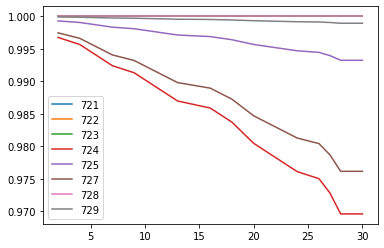

In [117]:
# cph_urti_no_abs_incdt.predict_survival_function(data_urti_no_abs_incdt)#_train, conditional_after=data_urti_no_abs_incdt_train.duration_urti_admitted)
survival_func_plot = cph_urti_no_abs_incdt.predict_survival_function(data_urti_no_abs_incdt)
plt.plot(survival_func_plot.loc[:, 720:729])
plt.legend(labels=survival_func_plot.loc[:, 720:729].columns, loc ="lower left")

In [118]:
# cph_urti_no_abs_incdt.plot_partial_effects_on_outcome(data_urti_no_abs_incdt.event_urti_admitted, values=[0, 2, 4, 6, 8, 10], cmap='coolwarm')

In [119]:
a = cph_urti_no_abs_incdt.baseline_hazard_
# cph_urti_no_abs_incdt.baseline_survival_
# cph_urti_no_abs_incdt.predict_cumulative_hazard(data_urti_no_abs_incdt, data_urti_no_abs_incdt['duration_urti_admitted']<=30)
# cph_urti_no_abs_incdt.predict_survival_function(data_urti_no_abs_incdt)

# save 
np.savetxt('../output/hospitalisation_prediction_urti/sum_betas_urti_no_abs_incdt.txt', a, delimiter=',')

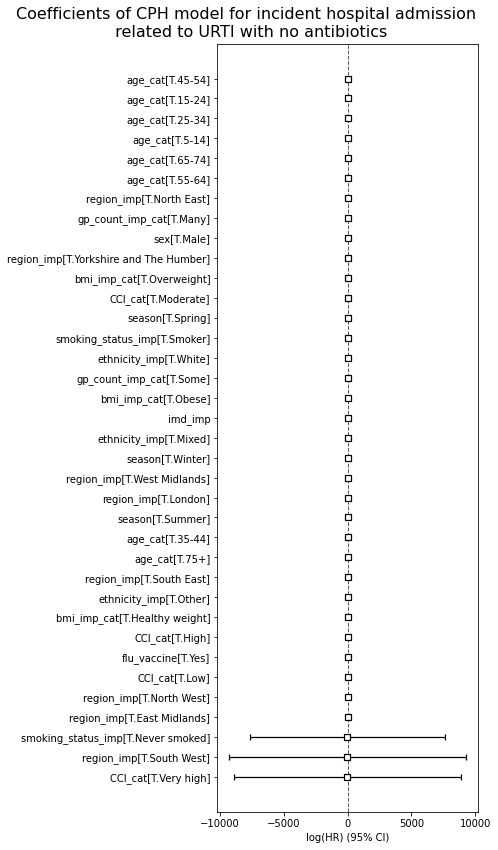

In [120]:
fig, ax = plt.subplots(figsize=(7, 12)
                        )
cph_urti_no_abs_incdt.plot()
plt.suptitle('Coefficients of CPH model for incident hospital admission \n related to URTI with no antibiotics', fontsize=16)
#_ = ax.set_yticklabels(['Age', 'BMI', 'GP consultations', 'CCI', 'IMD', 'Flu vaccine', 'Antibacterial prescriptions'], 
#                        rotation=45, fontsize=12, ha='right')
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/coefficients_cph_urti_no_abs_incdt.jpg', bbox_inches='tight')
plt.show()

In [121]:
# concordance index of cph model with training data
concord_index_urti_no_abs_incdt_train = concordance_index(data_urti_no_abs_incdt_train['duration_urti_admitted'], -cph_urti_no_abs_incdt.predict_partial_hazard(data_urti_no_abs_incdt_train), data_urti_no_abs_incdt_train['event_urti_admitted'])
print(f'Concordance index for urti_no_abs_incdt with training data: {concord_index_urti_no_abs_incdt_train}')

# concordance index of cph model with testing data
concord_index_urti_no_abs_incdt_test = concordance_index(data_urti_no_abs_incdt_test['duration_urti_admitted'], -cph_urti_no_abs_incdt.predict_partial_hazard(data_urti_no_abs_incdt_test), data_urti_no_abs_incdt_test['event_urti_admitted'])
print(f'Concordance index for urti_no_abs_incdt with testing data: {concord_index_urti_no_abs_incdt_test}')
# print(concordance_index(data_urti_no_abs_incdt_test['event_urti_admitted'], -cph_urti_no_abs_incdt.predict_partial_hazard(data_urti_no_abs_incdt_test), data_urti_no_abs_incdt_test['duration_urti_admitted']))

Concordance index for urti_no_abs_incdt with training data: 0.8522188585946093
Concordance index for urti_no_abs_incdt with testing data: 0.3974227858457762


In [122]:
# a = [concord_index_urti_no_abs_incdt_test]
# np.savetxt('../output/hospitalisation_prediction_urti/concord_index_urti_no_abs_incdt_test.txt', a, delimiter=',')

In [123]:
# fig, ax = plt.subplots(figsize=(8, 5)
#                         )
# survival_probability_calibration(cph_urti_no_abs_incdt, data_urti_no_abs_incdt_train, t0=30)
# # plt.suptitle('Calibration of CPH model for incident hospital admission related to urti with no antibiotics', fontsize=16)
# plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_no_abs_incdt_train.jpg', bbox_inches='tight')
# plt.show()

# # t0 (float) – the time to evaluate the probability of event occurring prior at.
# # ICI – mean absolute difference between predicted and observed
# # E50 – median absolute difference between predicted and observed

In [124]:
# fig, ax = plt.subplots(figsize=(8, 5)
#                         )
# survival_probability_calibration(cph_urti_no_abs_incdt, data_urti_no_abs_incdt_test, t0=30)
# # plt.suptitle('Calibration of CPH model for incident hospital admission related to URTI with no antibiotics', fontsize=16)
# plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_no_abs_incdt_test.jpg', bbox_inches='tight')
# plt.show()

In [125]:
cph_urti_no_abs_incdt_train_cumulative_hazard = cph_urti_no_abs_incdt.predict_cumulative_hazard(data_urti_no_abs_incdt_train)

cph_urti_no_abs_incdt_train_cumulative_hazard = cph_urti_no_abs_incdt_train_cumulative_hazard.loc[[30]].T

cph_urti_no_abs_incdt_train_cumulative_hazard['event_urti_admitted'] = data_urti_no_abs_incdt_train['event_urti_admitted']

cph_urti_no_abs_incdt_train_cumulative_hazard = cph_urti_no_abs_incdt_train_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, 
                                                inplace=False)

cph_urti_no_abs_incdt_train_cumulative_hazard

,cumulative_hazard,event_urti_admitted
4777,8.779866e-03,0.0
4061,1.334523e-10,0.0
2619,1.212153e-02,0.0
2148,4.991826e-03,0.0
3784,3.989432e-10,0.0
...,...,...
6361,1.501539e-18,0.0
669,4.347845e-11,0.0
4433,1.261092e-10,0.0
5427,2.366542e-11,0.0


In [126]:
cph_urti_no_abs_incdt_test_cumulative_hazard = cph_urti_no_abs_incdt.predict_cumulative_hazard(data_urti_no_abs_incdt_test)

cph_urti_no_abs_incdt_test_cumulative_hazard = cph_urti_no_abs_incdt_test_cumulative_hazard.loc[[30]].T

cph_urti_no_abs_incdt_test_cumulative_hazard['event_urti_admitted'] = data_urti_no_abs_incdt_test['event_urti_admitted']

cph_urti_no_abs_incdt_test_cumulative_hazard = cph_urti_no_abs_incdt_test_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, 
                                                inplace=False)

cph_urti_no_abs_incdt_test_cumulative_hazard

,cumulative_hazard,event_urti_admitted
3386,6.020591e-03,0.0
3684,3.795652e-10,0.0
984,2.868469e-03,0.0
5636,1.059923e-02,0.0
3586,1.234626e-02,0.0
...,...,...
6876,7.361114e-03,0.0
3700,8.711299e-03,0.0
5532,8.197003e-12,0.0
891,1.013143e-02,0.0


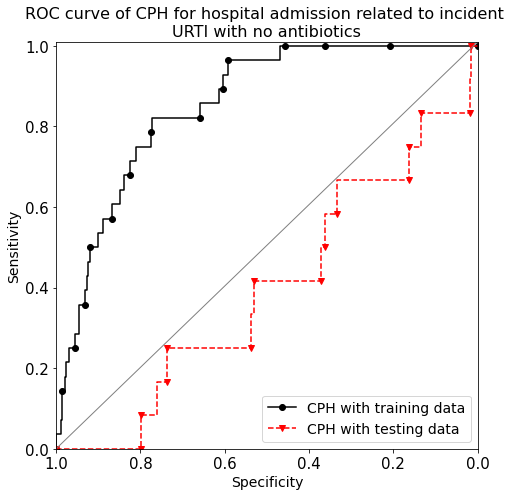

In [127]:
r_fpr1, r_tpr1, _ = roc_curve(cph_urti_no_abs_incdt_train_cumulative_hazard.event_urti_admitted, cph_urti_no_abs_incdt_train_cumulative_hazard.cumulative_hazard)
r_fpr2, r_tpr2, _ = roc_curve(cph_urti_no_abs_incdt_test_cumulative_hazard.event_urti_admitted, cph_urti_no_abs_incdt_test_cumulative_hazard.cumulative_hazard)

fig, ax1 = pyplot.subplots(figsize=(7, 7))

line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='CPH with training data')
line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='CPH with testing data')

squares = [0,1.01]
plt.plot(squares,linewidth=1, color='grey')
plt.ylim(0,1.01)
plt.xlim(0,1)
plt.xlabel('Specificity', fontsize=14)
plt.ylabel('Sensitivity', fontsize=14)

#reversing xticks
xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
x = np.arange(len(xticks))
ax1.set(xticklabels=xticks)
ax1.legend(fontsize=14)
plt.title('ROC curve of CPH for hospital admission related to incident \nURTI with no antibiotics', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15, rotation=0)
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/roc_curve_cph_urti_no_abs_incdt.png', bbox_inches='tight')
plt.show()

In [128]:
r_auc1 = roc_auc_score(cph_urti_no_abs_incdt_train_cumulative_hazard.event_urti_admitted, cph_urti_no_abs_incdt_train_cumulative_hazard.cumulative_hazard)
r_auc2 = roc_auc_score(cph_urti_no_abs_incdt_test_cumulative_hazard.event_urti_admitted, cph_urti_no_abs_incdt_test_cumulative_hazard.cumulative_hazard)
brier1 = brier_score_loss(cph_urti_no_abs_incdt_train_cumulative_hazard.event_urti_admitted, cph_urti_no_abs_incdt_train_cumulative_hazard.cumulative_hazard)
brier2 = brier_score_loss(cph_urti_no_abs_incdt_test_cumulative_hazard.event_urti_admitted, cph_urti_no_abs_incdt_test_cumulative_hazard.cumulative_hazard)

print('AUROC of CPH with training data of hospital admission related to incident URTI with no antibiotics = %.4f' % (r_auc1))
print('AUROC of CPH with testing data of hospital admission related to incident URTI with no antibiotics = %.4f' % (r_auc2))
print('Brier score of CPH with training data of hospital admission related to incident URTI with no antibiotics = %.4f' % (brier1))
print('Brier score of CPH with testing data of hospital admission related to incident URTI with no antibiotics = %.4f' % (brier2))

AUROC of CPH with training data of hospital admission related to incident URTI with no antibiotics = 0.8534
AUROC of CPH with testing data of hospital admission related to incident URTI with no antibiotics = 0.3969
Brier score of CPH with training data of hospital admission related to incident URTI with no antibiotics = 0.0074
Brier score of CPH with testing data of hospital admission related to incident URTI with no antibiotics = 0.0100


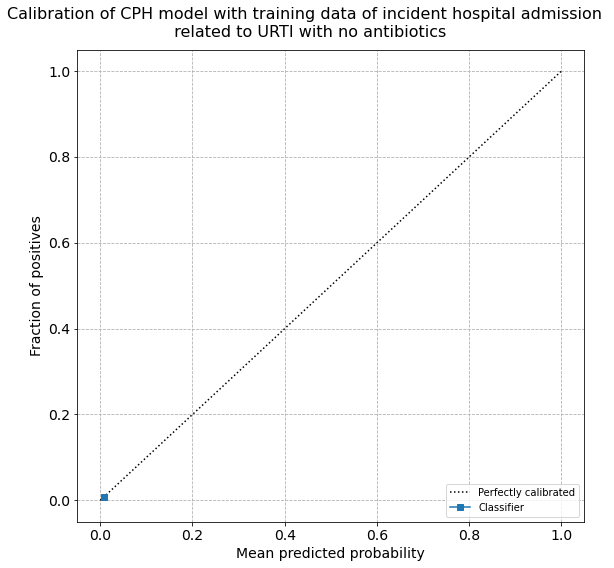

In [129]:
fig, axe = plt.subplots(figsize=(8, 8)
                        )

calib_cph_urti_no_abs_incdt_train = CalibrationDisplay.from_predictions(cph_urti_no_abs_incdt_train_cumulative_hazard.event_urti_admitted, cph_urti_no_abs_incdt_train_cumulative_hazard.cumulative_hazard, ax = axe)
plt.suptitle('Calibration of CPH model with training data of incident hospital admission \n related to URTI with no antibiotics', fontsize=16)
plt.xlabel('Mean predicted probability', fontsize=14)
plt.ylabel('Fraction of positives', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(visible=bool, linestyle='--')
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/calib_cph_urti_no_abs_incdt_train.jpg', bbox_inches='tight')
plt.show()

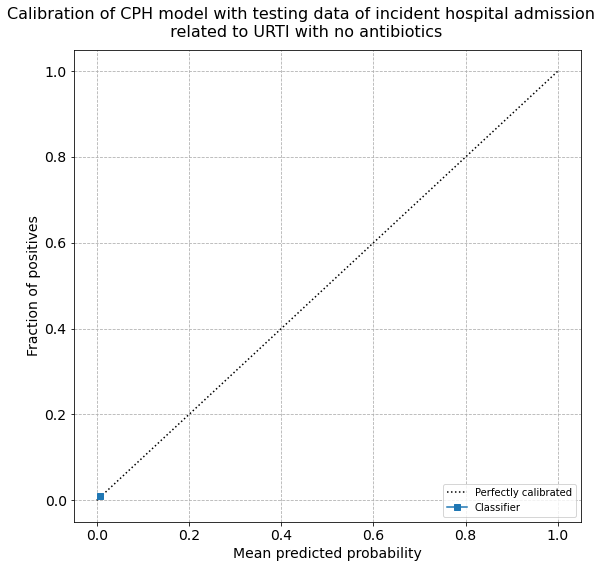

In [130]:
fig, axe = plt.subplots(figsize=(8, 8)
                        )

calib_cph_urti_no_abs_incdt_test = CalibrationDisplay.from_predictions(cph_urti_no_abs_incdt_test_cumulative_hazard.event_urti_admitted, cph_urti_no_abs_incdt_test_cumulative_hazard.cumulative_hazard, ax = axe)
plt.suptitle('Calibration of CPH model with testing data of incident hospital admission \n related to URTI with no antibiotics', fontsize=16)
plt.xlabel('Mean predicted probability', fontsize=14)
plt.ylabel('Fraction of positives', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(visible=bool, linestyle='--')
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/calib_cph_urti_no_abs_incdt_test.jpg', bbox_inches='tight')
plt.show()

In [131]:
# save model outputs
a = open("../output/hospitalisation_prediction_urti/cox_urti_no_abs_incdt_output.txt", "w")
a.write("")
a.writelines(['Concordance index for urti_no_abs_incdt with testing data: %.4f' % (concord_index_urti_no_abs_incdt_test), 
              '\nConcordance index for urti_no_abs_incdt with training data: %.4f' % (concord_index_urti_no_abs_incdt_train),
              '\nAUROC of CPH with training data of hospital admission related to incident URTI with no antibiotics = %.4f' % (r_auc1),
              '\nAUROC of CPH with testing data of hospital admission related to incident URTI with no antibiotics = %.4f' % (r_auc2),
              '\nBrier score of CPH with training data of hospital admission related to incident URTI with no antibiotics = %.4f' % (brier1),
              '\nBrier score of CPH with testing data of hospital admission related to incident URTI with no antibiotics = %.4f' % (brier2)])

#### 4-1-2- Incident hospital admission related to URTI with antibiotics

In [132]:
data_urti_abs_incdt.columns

Index(['Age_cat', 'msoa', 'age', 'age_cat', 'sex', 'bmi_imp', 'bmi_imp_cat',
       'gp_count', 'gp_count_imp_cat', 'gp_count_imp', 'flu_vaccine',
       'region_imp', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp',
       'ethnicity_imp', 'antibacterial_brit_imp', 'antibacterial_brit_cat',
       'hx_hosp', 'CCI_cat', 'CCI', 'meds_nonabs', 'meds_nonabs_cat',
       'died_date', 'deregistered_date', 'gp_cons_urti', 'gp_cons_urti_ab',
       'urti_date', 'incdt_urti_date', 'admitted_urti_date',
       'sgss_gp_cov_urti_date', 'date', 'season', 'date_month',
       'event_urti_admitted', 'delta_urti_admitted', 'delta_admitted_died',
       'delta_admitted_deregistered', 'delta_admitted_died_deregistered',
       'duration_urti_admitted'],
      dtype='object')

In [133]:
data_urti_abs_incdt.shape

(537, 40)

In [134]:
#keep relevant variables
data_urti_abs_incdt = data_urti_abs_incdt[['age_cat', 'sex', 'CCI_cat', 'age', 'bmi_imp', 'bmi_imp_cat', 
                                           'gp_count_imp', 'gp_count_imp_cat', 'flu_vaccine', 'region_imp', 'season', 
                                           'imd_imp', 'antibacterial_brit_imp', 'ethnicity_imp', 'antibacterial_brit_cat',
                                           'smoking_status_imp', 'meds_nonabs', 'meds_nonabs_cat',
                                           'event_urti_admitted', 'duration_urti_admitted']]

In [135]:
# printing number of missing values in each variable 
data_urti_abs_incdt.isnull().sum()

age_cat                   0
sex                       0
CCI_cat                   0
age                       0
bmi_imp                   0
bmi_imp_cat               0
gp_count_imp              0
gp_count_imp_cat          0
flu_vaccine               0
region_imp                0
season                    0
imd_imp                   0
antibacterial_brit_imp    0
ethnicity_imp             0
antibacterial_brit_cat    0
smoking_status_imp        0
meds_nonabs               0
meds_nonabs_cat           0
event_urti_admitted       0
duration_urti_admitted    0
dtype: int64

In [136]:
# #drop ros with missing values
# data_urti_abs_incdt = data_urti_abs_incdt.dropna(axis='rows')
# #data_urti_abs_incdt = data_urti_abs_incdt.drop(columns=['smoking_status'])
# data_urti_abs_incdt.isnull().sum()

In [137]:
#randomly splitting data into training (%75) and testing (%25)
data_urti_abs_incdt_train, data_urti_abs_incdt_test = train_test_split(data_urti_abs_incdt, test_size=0.25, random_state=42)

print(f'shape of data_urti_abs_incdt for training: {data_urti_abs_incdt_train.shape}')
print(f'shape of data_urti_abs_incdt for testing: {data_urti_abs_incdt_test.shape}')

shape of data_urti_abs_incdt for training: (402, 20)
shape of data_urti_abs_incdt for testing: (135, 20)


In [247]:
cph_urti_abs_incdt = CoxPHFitter().fit(data_urti_abs_incdt_train,
        duration_col='duration_urti_admitted',
        event_col='event_urti_admitted',
        formula="age_cat + sex + CCI_cat + gp_count_imp_cat + flu_vaccine + bmi_imp_cat + region_imp + imd_imp + ethnicity_imp + smoking_status_imp + season + antibacterial_brit_cat + meds_nonabs_cat"
        )
cph_urti_abs_incdt.print_summary()

<lifelines.CoxPHFitter: fitted with 402 total observations, 399 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 402
number of events observed = 3
   partial log-likelihood = -0.00
         time fit was run = 2022-05-13 09:43:42 UTC

---
                                         coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                      
CCI_cat[T.Low]                           7.37    1587.36    2582.67         -5054.56          5069.30                 0.00                  inf
CCI_cat[T.Moderate]                     22.43   5.52e+09    3478.27         -6794.86          6839.72                 0.00                  inf
CCI_cat[T.High]                          1.57       4.82    6998.79        -13715.80         13718.95                 0.00                  inf
CCI_cat[T.Very high]                     0.12       1.12    5486.23        -10752.69         10752.92                 0.00                  inf
age_cat[T.15-24]                       -10.18       0.00    7372.66        -14460.33         14439.97                 0.00                  inf
age_cat[T.25-34]                       -21.80       0.00    7207.00        -14147.26         14103.65                 0.00                  inf
age_cat[T.35-44]                        -3.49       0.03    5450.06        -10685.41         10678.44                 0.00                  inf
age_cat[T.45-54]                       -12.97       0.00    9354.87        -18348.18         18322.23                 0.00                  inf
age_cat[T.5-14]                         12.83   3.74e+05    5054.09         -9893.00          9918.66                 0.00                  inf
age_cat[T.55-64]                        -9.13       0.00    4589.97         -9005.31          8987.06                 0.00                  inf
age_cat[T.65-74]                        -3.50       0.03    4728.91         -9272.00          9265.00                 0.00                  inf
age_cat[T.75+]                         -14.00       0.00    6085.74        -11941.83         11913.83                 0.00                  inf
antibacterial_brit_cat[T.Some]          -9.42       0.00    4571.06         -8968.54          8949.69                 0.00                  inf
antibacterial_brit_cat[T.Many]         -10.77       0.00    8338.57        -16354.06         16332.52                 0.00                  inf
bmi_imp_cat[T.Healthy weight]            0.50       1.65   11334.84        -22215.37         22216.38                 0.00                  inf
bmi_imp_cat[T.Overweight]               -7.07       0.00    9283.68        -18202.75         18188.62                 0.00                  inf
bmi_imp_cat[T.Obese]                     0.60       1.82    2386.91         -4677.66          4678.85                 0.00                  inf
ethnicity_imp[T.Mixed]                   7.62    2035.04    4631.27         -9069.50          9084.73                 0.00                  inf
ethnicity_imp[T.Other]                 -17.79       0.00    9396.87        -18435.32         18399.74                 0.00                  inf
ethnicity_imp[T.White]                  -7.03       0.00    4337.16         -8507.71          8493.65                 0.00                  inf
flu_vaccine[T.Yes]                      -1.89       0.15    7092.71        -13903.34         13899.55                 0.00                  inf
gp_count_imp_cat[T.Some]                 1.59       4.92    2805.37         -5496.83          5500.02                 0.00                  inf
gp_count_imp_cat[T.Many]                -8.78       0.00    4930.40         -9672.19          9654.64                 0.00                  inf
imd_imp        

In [139]:
output = GetPrintSummary(cph_urti_abs_incdt)

with open('../output/hospitalisation_prediction_urti/cph_urti_abs_incdt_summary.html', "w") as fo:
    print(fo.write(output))
    fo.close()

12626


In [140]:
a = cph_urti_abs_incdt.baseline_hazard_
# cph_urti_abs_incdt.baseline_survival_
# cph_urti_abs_incdt.predict_cumulative_hazard(data_urti_abs_incdt, data_urti_abs_incdt['duration_urti_admitted']<=30)
# cph_urti_abs_incdt.predict_survival_function(data_urti_abs_incdt)

# save 
np.savetxt('../output/hospitalisation_prediction_urti/sum_betas_urti_abs_incdt.txt', a, delimiter=',')

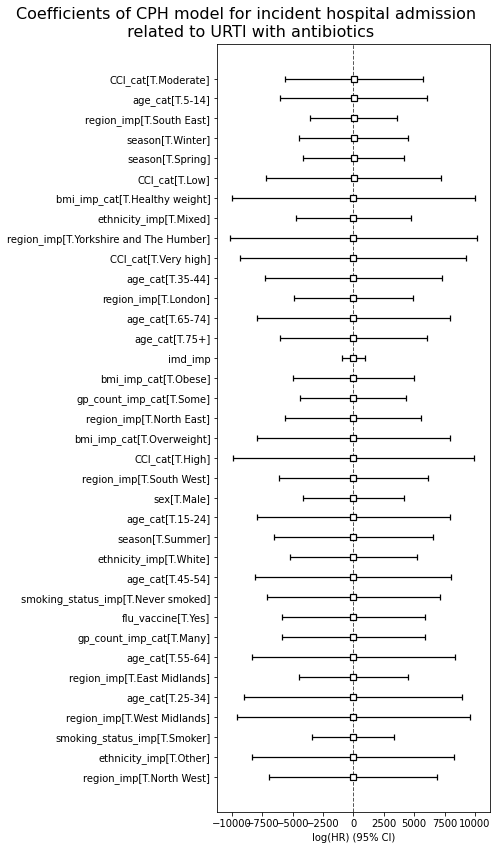

In [141]:
fig, ax = plt.subplots(figsize=(7, 12)
                        )
cph_urti_abs_incdt.plot()
plt.suptitle('Coefficients of CPH model for incident hospital admission \n related to URTI with antibiotics', fontsize=16)
#_ = ax.set_yticklabels(['Age', 'BMI', 'GP consultations', 'CCI', 'IMD', 'Flu vaccine', 'Antibacterial prescriptions'], 
#                        rotation=45, fontsize=12, ha='right')
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/coefficients_cph_urti_abs_incdt.jpg', bbox_inches='tight')
plt.show()

In [142]:
# concordance index of cph model with training data
concord_index_urti_abs_incdt_train = concordance_index(data_urti_abs_incdt_train['duration_urti_admitted'], -cph_urti_abs_incdt.predict_partial_hazard(data_urti_abs_incdt_train), data_urti_abs_incdt_train['event_urti_admitted'])
print(f'Concordance index for urti_abs_incdt with training data: {concord_index_urti_abs_incdt_train}')

# concordance index of cph model with testing data
concord_index_urti_abs_incdt_test = concordance_index(data_urti_abs_incdt_test['duration_urti_admitted'], -cph_urti_abs_incdt.predict_partial_hazard(data_urti_abs_incdt_test), data_urti_abs_incdt_test['event_urti_admitted'])
print(f'Concordance index for urti_abs_incdt with testing data: {concord_index_urti_abs_incdt_test}')

Concordance index for urti_abs_incdt with training data: 1.0
Concordance index for urti_abs_incdt with testing data: 0.06716417910447761


In [143]:
# a = [concord_index_urti_abs_incdt_test]
# np.savetxt('../output/hospitalisation_prediction_urti/concord_index_urti_abs_incdt_test.txt', a, delimiter=',')

In [144]:
# fig, ax = plt.subplots(figsize=(8, 5)
#                         )
# survival_probability_calibration(cph_urti_abs_incdt, data_urti_abs_incdt_train, t0=30)
# # plt.suptitle('Calibration of CPH model for incident hospital admission related to URTI with antibiotics', fontsize=16)
# plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_abs_incdt_train.jpg', bbox_inches='tight')
# plt.show()

In [145]:
# survival_probability_calibration(cph_urti_abs_incdt, data_urti_abs_incdt, t0=30)

In [146]:
# survival_probability_calibration(cph_urti_abs_incdt, data_urti_abs_incdt_train, t0=30)

In [147]:
# fig, ax = plt.subplots(figsize=(8, 5)
#                         )
# survival_probability_calibration(cph_urti_abs_incdt, data_urti_abs_incdt_test, t0=30)
# # plt.suptitle('Calibration of CPH model for incident hospital admission related to urti with antibiotics', fontsize=16)
# plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_abs_incdt_test.jpg', bbox_inches='tight')
# plt.show()

In [148]:
cph_urti_abs_incdt_train_cumulative_hazard = cph_urti_abs_incdt.predict_cumulative_hazard(data_urti_abs_incdt_train)

cph_urti_abs_incdt_train_cumulative_hazard = cph_urti_abs_incdt_train_cumulative_hazard.loc[[30]].T

cph_urti_abs_incdt_train_cumulative_hazard['event_urti_admitted'] = data_urti_abs_incdt_train['event_urti_admitted']

cph_urti_abs_incdt_train_cumulative_hazard = cph_urti_abs_incdt_train_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, 
                                                inplace=False)

cph_urti_abs_incdt_train_cumulative_hazard

,cumulative_hazard,event_urti_admitted
6233,1.408062e-13,0.0
2980,4.434049e-29,0.0
3320,3.357545e-22,0.0
5593,8.801584e-16,0.0
268,1.577056e-30,0.0
...,...,...
1090,1.617987e-16,0.0
1572,1.135200e-11,0.0
3585,1.445441e-18,0.0
5733,1.126391e-19,0.0


In [149]:
cph_urti_abs_incdt_test_cumulative_hazard = cph_urti_abs_incdt.predict_cumulative_hazard(data_urti_abs_incdt_test)

cph_urti_abs_incdt_test_cumulative_hazard = cph_urti_abs_incdt_test_cumulative_hazard.loc[[30]].T

cph_urti_abs_incdt_test_cumulative_hazard['event_urti_admitted'] = data_urti_abs_incdt_test['event_urti_admitted']

cph_urti_abs_incdt_test_cumulative_hazard = cph_urti_abs_incdt_test_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, 
                                                inplace=False)

cph_urti_abs_incdt_test_cumulative_hazard

,cumulative_hazard,event_urti_admitted
6430,4.019065e-25,0.0
1133,3.718864e-28,0.0
4540,2.800420e-27,0.0
1293,5.826507e-40,0.0
6095,2.316411e-25,0.0
...,...,...
5964,5.338514e-21,0.0
5626,2.701258e-19,0.0
2475,1.603904e-27,0.0
4638,6.284652e-38,0.0


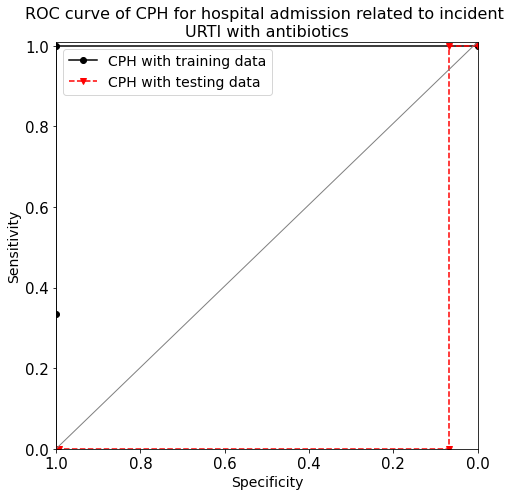

In [150]:
r_fpr1, r_tpr1, _ = roc_curve(cph_urti_abs_incdt_train_cumulative_hazard.event_urti_admitted, cph_urti_abs_incdt_train_cumulative_hazard.cumulative_hazard)
r_fpr2, r_tpr2, _ = roc_curve(cph_urti_abs_incdt_test_cumulative_hazard.event_urti_admitted, cph_urti_abs_incdt_test_cumulative_hazard.cumulative_hazard)

fig, ax1 = pyplot.subplots(figsize=(7, 7))

line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='CPH with training data')
line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='CPH with testing data')

squares = [0,1.01]
plt.plot(squares,linewidth=1, color='grey')
plt.ylim(0,1.01)
plt.xlim(0,1)
plt.xlabel('Specificity', fontsize=14)
plt.ylabel('Sensitivity', fontsize=14)

#reversing xticks
xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
x = np.arange(len(xticks))
ax1.set(xticklabels=xticks)
ax1.legend(fontsize=14)
plt.title('ROC curve of CPH for hospital admission related to incident \nURTI with antibiotics', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15, rotation=0)
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/roc_curve_cph_urti_abs_incdt.png', bbox_inches='tight')
plt.show()

In [ ]:
cph_urti_abs_incdt_test_cumulative_hazard.cumulative_hazard.max()

0.28969018335403734

In [ ]:
# cph_urti_abs_incdt_train_cumulative_hazard.describe()
cph_urti_abs_incdt_train_cumulative_hazard.cumulative_hazard.max()

1.2030254372416918

In [ ]:
cph_urti_abs_incdt_train_cumulative_hazard.shape

(417, 2)

In [ ]:
cph_urti_abs_incdt_train_cumulative_hazard = cph_urti_abs_incdt_train_cumulative_hazard[cph_urti_abs_incdt_train_cumulative_hazard.cumulative_hazard <= 1]
cph_urti_abs_incdt_train_cumulative_hazard.max()

cumulative_hazard      0.787467
event_urti_admitted    1.000000
dtype: float64

In [ ]:
cph_urti_abs_incdt_train_cumulative_hazard.shape

(416, 2)

In [ ]:
r_auc1 = roc_auc_score(cph_urti_abs_incdt_train_cumulative_hazard.event_urti_admitted, cph_urti_abs_incdt_train_cumulative_hazard.cumulative_hazard)
r_auc2 = roc_auc_score(cph_urti_abs_incdt_test_cumulative_hazard.event_urti_admitted, cph_urti_abs_incdt_test_cumulative_hazard.cumulative_hazard)
brier1 = brier_score_loss(cph_urti_abs_incdt_train_cumulative_hazard.event_urti_admitted, cph_urti_abs_incdt_train_cumulative_hazard.cumulative_hazard)
brier2 = brier_score_loss(cph_urti_abs_incdt_test_cumulative_hazard.event_urti_admitted, cph_urti_abs_incdt_test_cumulative_hazard.cumulative_hazard)

print('AUROC of CPH with training data of hospital admission related to incident URTI with antibiotics = %.4f' % (r_auc1))
print('AUROC of CPH with testing data of hospital admission related to incident URTI with antibiotics = %.4f' % (r_auc2))
print('Brier score of CPH with training data of hospital admission related to incident URTI with antibiotics = %.4f' % (brier1))
print('Brier score of CPH with testing data of hospital admission related to incident URTI with antibiotics = %.4f' % (brier2))

AUROC of CPH with training data of hospital admission related to incident URTI with antibiotics = 0.9968
AUROC of CPH with testing data of hospital admission related to incident URTI with antibiotics = 0.6373
Brier score of CPH with training data of hospital admission related to incident URTI with antibiotics = 0.0045
Brier score of CPH with testing data of hospital admission related to incident URTI with antibiotics = 0.0218


In [250]:
fig, axe = plt.subplots(figsize=(8, 8)
                        )

calib_cph_urti_abs_incdt_train = CalibrationDisplay.from_predictions(cph_urti_abs_incdt_train_cumulative_hazard.event_urti_admitted, cph_urti_abs_incdt_train_cumulative_hazard.cumulative_hazard, ax = axe)
plt.suptitle('Calibration of CPH model with training data of incident hospital admission \n related to URTI with antibiotics', fontsize=16)
plt.xlabel('Mean predicted probability', fontsize=14)
plt.ylabel('Fraction of positives', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(visible=bool, linestyle='--')
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/calib_cph_urti_abs_incdt_train.jpg', bbox_inches='tight')
plt.show()

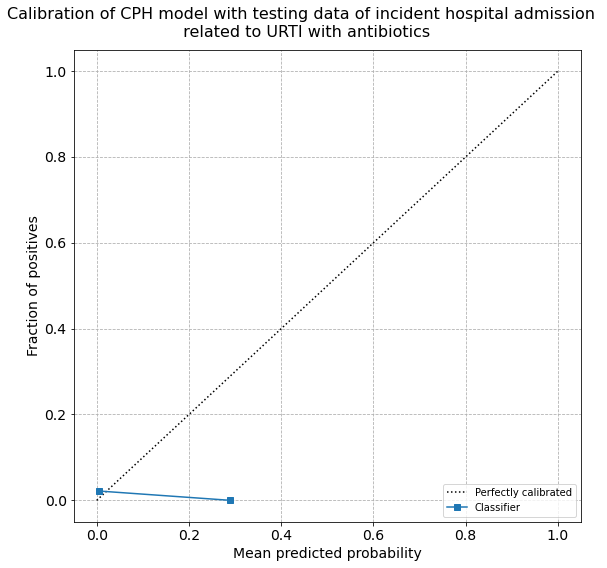

In [ ]:
fig, axe = plt.subplots(figsize=(8, 8)
                        )

calib_cph_urti_abs_incdt_train = CalibrationDisplay.from_predictions(cph_urti_abs_incdt_test_cumulative_hazard.event_urti_admitted, cph_urti_abs_incdt_test_cumulative_hazard.cumulative_hazard, ax = axe)
plt.suptitle('Calibration of CPH model with testing data of incident hospital admission \n related to URTI with antibiotics', fontsize=16)
plt.xlabel('Mean predicted probability', fontsize=14)
plt.ylabel('Fraction of positives', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(visible=bool, linestyle='--')
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/calib_cph_urti_abs_incdt_test.jpg', bbox_inches='tight')
plt.show()

In [152]:
# save model outputs
a = open("../output/hospitalisation_prediction_urti/cox_urti_abs_incdt_output.txt", "w")
a.write("")
a.writelines(['Concordance index for urti_abs_incdt with testing data: %.4f' % (concord_index_urti_abs_incdt_test), 
              '\nConcordance index for urti_abs_incdt with training data: %.4f' % (concord_index_urti_abs_incdt_train),
              '\nAUROC of CPH with training data of hospital admission related to incident URTI with antibiotics = %.4f' % (r_auc1),
              '\nAUROC of CPH with testing data of hospital admission related to incident URTI with antibiotics = %.4f' % (r_auc2),
              '\nBrier score of CPH with training data of hospital admission related to incident URTI with antibiotics = %.4f' % (brier1),
              '\nBrier score of CPH with testing data of hospital admission related to incident URTI with antibiotics = %.4f' % (brier2)])

#### 4-1-3- Prevalent hospital admission related to URTI with no antibiotics

In [ ]:
data_urti_no_abs_prevl.columns

Index(['Age_cat', 'msoa', 'age', 'age_cat', 'sex', 'bmi_imp', 'bmi_imp_cat',
       'gp_count', 'gp_count_imp_cat', 'gp_count_imp', 'flu_vaccine',
       'region_imp', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp',
       'ethnicity_imp', 'antibacterial_brit_imp', 'antibacterial_brit_cat',
       'hx_hosp', 'CCI_cat', 'CCI', 'meds_nonabs', 'meds_nonabs_cat',
       'died_date', 'deregistered_date', 'gp_cons_urti', 'gp_cons_urti_ab',
       'urti_date', 'incdt_urti_date', 'admitted_urti_date',
       'sgss_gp_cov_urti_date', 'date', 'season', 'date_month',
       'event_urti_admitted', 'delta_urti_admitted', 'delta_admitted_died',
       'delta_admitted_deregistered', 'delta_admitted_died_deregistered',
       'duration_urti_admitted'],
      dtype='object')

In [ ]:
data_urti_no_abs_prevl.shape

(572, 40)

In [153]:
#keep relevant variables
data_urti_no_abs_prevl = data_urti_no_abs_prevl[['age_cat', 'sex', 'CCI_cat', 'age', 'bmi_imp', 'bmi_imp_cat', 
                                                 'gp_count_imp', 'gp_count_imp_cat', 'flu_vaccine', 'region_imp', 'season', 
                                                 'imd_imp', 'antibacterial_brit_imp', 'ethnicity_imp', 'antibacterial_brit_cat',
                                                 'smoking_status_imp', 'meds_nonabs', 'meds_nonabs_cat',
                                                 'event_urti_admitted', 'duration_urti_admitted']]

In [154]:
# printing number of missing values in each variable 
data_urti_no_abs_prevl.isnull().sum()

age_cat                   0
sex                       0
CCI_cat                   0
age                       0
bmi_imp                   0
bmi_imp_cat               0
gp_count_imp              0
gp_count_imp_cat          0
flu_vaccine               0
region_imp                0
season                    0
imd_imp                   0
antibacterial_brit_imp    0
ethnicity_imp             0
antibacterial_brit_cat    0
smoking_status_imp        0
meds_nonabs               0
meds_nonabs_cat           0
event_urti_admitted       0
duration_urti_admitted    0
dtype: int64

In [155]:
#randomly splitting data into training (%75) and testing (%25)
data_urti_no_abs_prevl_train, data_urti_no_abs_prevl_test = train_test_split(data_urti_no_abs_prevl, test_size=0.25, random_state=42)

print(f'shape of data_urti_no_abs_prevl for training: {data_urti_no_abs_prevl_train.shape}')
print(f'shape of data_urti_no_abs_prevl for testing: {data_urti_no_abs_prevl_test.shape}')

shape of data_urti_no_abs_prevl for training: (417, 20)
shape of data_urti_no_abs_prevl for testing: (140, 20)


In [251]:
cph_urti_no_abs_prevl = CoxPHFitter().fit(data_urti_no_abs_prevl_train,
        duration_col='duration_urti_admitted',
        event_col='event_urti_admitted',
        formula="age_cat + sex + CCI_cat + gp_count_imp_cat + flu_vaccine + bmi_imp_cat + region_imp + imd_imp + ethnicity_imp + smoking_status_imp + season + antibacterial_brit_cat + meds_nonabs_cat"
        )
cph_urti_no_abs_prevl.print_summary()

<lifelines.CoxPHFitter: fitted with 417 total observations, 416 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 417
number of events observed = 1
   partial log-likelihood = -0.00
         time fit was run = 2022-05-13 09:47:17 UTC

---
                                         coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                      
CCI_cat[T.Low]                          -4.97       0.01   15328.14        -30047.57         30037.63                 0.00                  inf
CCI_cat[T.Moderate]                     -2.67       0.07   18039.08        -35358.62         35353.29                 0.00                  inf
CCI_cat[T.High]                         -2.49       0.08   18921.98        -37088.88         37083.91                 0.00                  inf
CCI_cat[T.Very high]                    -5.86       0.00   21938.87        -43005.25         42993.52                 0.00                  inf
age_cat[T.15-24]                        -1.22       0.30   24128.48        -47292.17         47289.74                 0.00                  inf
age_cat[T.25-34]                        -0.40       0.67   27218.03        -53346.75         53345.96                 0.00                  inf
age_cat[T.35-44]                        -0.84       0.43   24501.68        -48023.24         48021.57                 0.00                  inf
age_cat[T.45-54]                        -0.53       0.59   22232.16        -43574.76         43573.71                 0.00                  inf
age_cat[T.5-14]                         -1.26       0.28   24392.59        -47809.85         47807.34                 0.00                  inf
age_cat[T.55-64]                         3.81      44.93   20174.84        -39538.15         39545.76                 0.00                  inf
age_cat[T.65-74]                        -0.90       0.41   27093.15        -53102.50         53100.70                 0.00                  inf
age_cat[T.75+]                          -0.04       0.96   24999.91        -48998.96         48998.87                 0.00                  inf
antibacterial_brit_cat[T.Some]           0.21       1.23   16001.56        -31362.26         31362.69                 0.00                  inf
antibacterial_brit_cat[T.Many]          -3.11       0.04   23398.48        -45863.29         45857.07                 0.00                  inf
bmi_imp_cat[T.Healthy weight]           -0.47       0.63   27226.89        -53364.19         53363.25                 0.00                  inf
bmi_imp_cat[T.Overweight]               -1.64       0.19   21910.07        -42944.60         42941.31                 0.00                  inf
bmi_imp_cat[T.Obese]                     0.40       1.50   12248.69        -24006.59         24007.40                 0.00                  inf
ethnicity_imp[T.Mixed]                   4.35      77.60   23789.08        -46621.39         46630.09                 0.00                  inf
ethnicity_imp[T.Other]                   1.68       5.35   32826.53        -64337.14         64340.49                 0.00                  inf
ethnicity_imp[T.White]                  -0.67       0.51   25691.06        -50354.23         50352.88                 0.00                  inf
flu_vaccine[T.Yes]                       0.51       1.66   20061.82        -39319.94         39320.95                 0.00                  inf
gp_count_imp_cat[T.Some]                -1.15       0.32   14609.29        -28634.83         28632.53                 0.00                  inf
gp_count_imp_cat[T.Many]                 3.96      52.33   10942.98        -21443.89         21451.81                 0.00                  inf
imd_imp        

In [ ]:
output = GetPrintSummary(cph_urti_no_abs_prevl)

with open('../output/hospitalisation_prediction_urti/cph_urti_no_abs_prevl_summary.html', "w") as fo:
    print(fo.write(output))
    fo.close()

12625


In [ ]:
a = cph_urti_no_abs_prevl.baseline_hazard_
# cph_urti_no_abs_prevl.baseline_survival_
# cph_urti_no_abs_prevl.predict_cumulative_hazard(data_urti_no_abs_prevl, data_urti_no_abs_prevl['duration_urti_admitted']<=30)
# cph_urti_no_abs_prevl.predict_survival_function(data_urti_no_abs_prevl)

# save 
np.savetxt('../output/hospitalisation_prediction_urti/sum_betas_urti_no_abs_prevl.txt', a, delimiter=',')

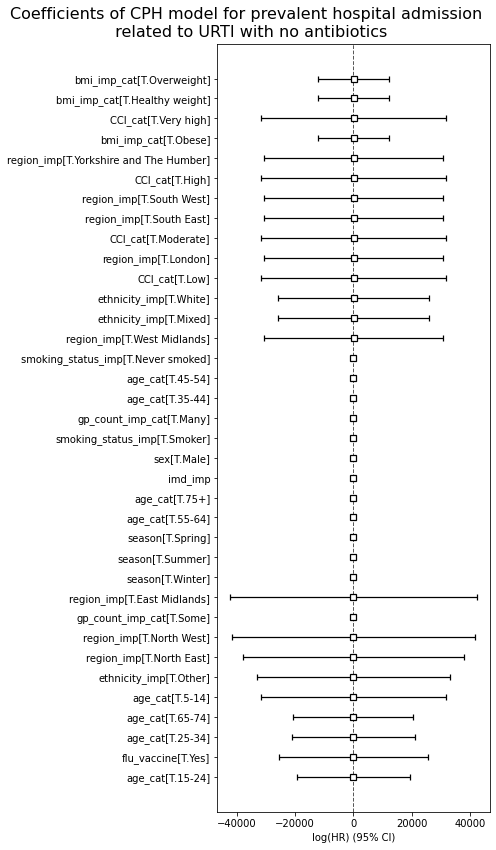

In [ ]:
fig, ax = plt.subplots(figsize=(7, 12)
                        )
cph_urti_no_abs_prevl.plot()
plt.suptitle('Coefficients of CPH model for prevalent hospital admission \n related to URTI with no antibiotics', fontsize=16)
#_ = ax.set_yticklabels(['Age', 'BMI', 'GP consultations', 'CCI', 'IMD', 'Flu vaccine', 'Antibacterial prescriptions'], 
#                        rotation=45, fontsize=12, ha='right')
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/coefficients_cph_urti_no_abs_prevl.jpg', bbox_inches='tight')
plt.show()

In [ ]:
# data_urti_no_abs_prevl_test.columns

In [ ]:
# concordance index of cph model with training data
concord_index_urti_no_abs_prevl_train = concordance_index(data_urti_no_abs_prevl_train['duration_urti_admitted'], -cph_urti_no_abs_prevl.predict_partial_hazard(data_urti_no_abs_prevl_train), data_urti_no_abs_prevl_train['event_urti_admitted'])
print(f'Concordance index for cph_urti_no_abs_prevl with training data: {concord_index_urti_no_abs_prevl_train}')

# concordance index of cph model with testing data
concord_index_urti_no_abs_prevl_test = concordance_index(data_urti_no_abs_prevl_test['duration_urti_admitted'], -cph_urti_no_abs_prevl.predict_partial_hazard(data_urti_no_abs_prevl_test), data_urti_no_abs_prevl_test['event_urti_admitted'])
print(f'Concordance index for cph_urti_no_abs_prevl with testing data: {concord_index_urti_no_abs_prevl_test}')

Concordance index for cph_urti_no_abs_prevl with training data: 0.9805042016806723


In [ ]:
# a = [concord_index_urti_no_abs_prevl_test]
# np.savetxt('../output/hospitalisation_prediction_urti/concord_index_urti_no_abs_prevl_test.txt', a, delimiter=',')

In [ ]:
# fig, ax = plt.subplots(figsize=(8, 5)
#                         )
# survival_probability_calibration(cph_urti_no_abs_prevl, data_urti_no_abs_prevl_train, t0=30)
# # plt.suptitle('Calibration of CPH model for prevalent hospital admission related to URTI with no antibiotics', fontsize=16)
# plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_no_abs_prevl_train.jpg', bbox_inches='tight')
# plt.show()

In [ ]:
# fig, ax = plt.subplots(figsize=(8, 5)
#                         )
# survival_probability_calibration(cph_urti_no_abs_prevl, data_urti_no_abs_prevl_test, t0=30)
# plt.suptitle('Calibration of CPH model for prevalent hospital admission related to URTI with no antibiotics', fontsize=16)
# plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_no_abs_prevl_test.jpg', bbox_inches='tight')
# plt.show()

In [ ]:
cph_urti_no_abs_prevl_train_cumulative_hazard = cph_urti_no_abs_prevl.predict_cumulative_hazard(data_urti_no_abs_prevl_train)

cph_urti_no_abs_prevl_train_cumulative_hazard = cph_urti_no_abs_prevl_train_cumulative_hazard.loc[[30]].T

cph_urti_no_abs_prevl_train_cumulative_hazard['event_urti_admitted'] = data_urti_no_abs_prevl_train['event_urti_admitted']

cph_urti_no_abs_prevl_train_cumulative_hazard = cph_urti_no_abs_prevl_train_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, 
                                                inplace=False)

cph_urti_no_abs_prevl_train_cumulative_hazard

,cumulative_hazard,event_urti_admitted
4092,1.356525e-20,0.0
2023,1.061601e-32,0.0
6677,1.192019e-16,0.0
3392,9.408296e-02,0.0
6489,1.633944e-10,0.0
...,...,...
1104,1.623050e-16,0.0
1547,1.262701e-14,0.0
3811,1.122519e-34,0.0
5851,1.338194e-03,0.0


In [ ]:
cph_urti_no_abs_prevl_test_cumulative_hazard = cph_urti_no_abs_prevl.predict_cumulative_hazard(data_urti_no_abs_prevl_test)

cph_urti_no_abs_prevl_test_cumulative_hazard = cph_urti_no_abs_prevl_test_cumulative_hazard.loc[[30]].T

cph_urti_no_abs_prevl_test_cumulative_hazard['event_urti_admitted'] = data_urti_no_abs_prevl_test['event_urti_admitted']

cph_urti_no_abs_prevl_test_cumulative_hazard = cph_urti_no_abs_prevl_test_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, 
                                                inplace=False)

cph_urti_no_abs_prevl_test_cumulative_hazard

,cumulative_hazard,event_urti_admitted
6651,1.214930e-02,0.0
1103,1.681396e+03,0.0
1887,6.386028e-18,0.0
5451,3.911832e-14,0.0
6970,2.482630e-14,0.0
...,...,...
1334,5.824994e-15,0.0
5619,6.467368e-12,0.0
2452,1.026096e-14,0.0
286,4.532356e-23,0.0


In [ ]:
# cph_urti_no_abs_prevl.predict_cumulative_hazard(data_urti_no_abs_prevl_test)[[1103, 188, 6651]]

In [ ]:
r_fpr1, r_tpr1, _ = roc_curve(cph_urti_no_abs_prevl_train_cumulative_hazard.event_urti_admitted, cph_urti_no_abs_prevl_train_cumulative_hazard.cumulative_hazard)
r_fpr2, r_tpr2, _ = roc_curve(cph_urti_no_abs_prevl_test_cumulative_hazard.event_urti_admitted, cph_urti_no_abs_prevl_test_cumulative_hazard.cumulative_hazard)

fig, ax1 = pyplot.subplots(figsize=(7, 7))

line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='CPH with training data')
line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='CPH with testing data')

squares = [0,1.01]
plt.plot(squares,linewidth=1, color='grey')
plt.ylim(0,1.01)
plt.xlim(0,1)
plt.xlabel('Specificity', fontsize=14)
plt.ylabel('Sensitivity', fontsize=14)

#reversing xticks
xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
x = np.arange(len(xticks))
ax1.set(xticklabels=xticks)
ax1.legend(fontsize=14)
plt.title('ROC curve of CPH for hospital admission related to prevalent \nURTI with no antibiotics', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15, rotation=0)
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/roc_curve_cph_urti_no_abs_prevl.png', bbox_inches='tight')
plt.show()

In [169]:
cph_urti_no_abs_prevl_train_cumulative_hazard.shape

(429, 2)

In [170]:
cph_urti_no_abs_prevl_train_cumulative_hazard.max()

cumulative_hazard      7.106619
event_urti_admitted    1.000000
dtype: float64

In [171]:
cph_urti_no_abs_prevl_train_cumulative_hazard = cph_urti_no_abs_prevl_train_cumulative_hazard[cph_urti_no_abs_prevl_train_cumulative_hazard.cumulative_hazard <= 1]
cph_urti_no_abs_prevl_train_cumulative_hazard.max()

cumulative_hazard      0.669541
event_urti_admitted    1.000000
dtype: float64

In [172]:
cph_urti_no_abs_prevl_train_cumulative_hazard.shape

(426, 2)

In [318]:
r_auc1 = roc_auc_score(cph_urti_no_abs_prevl_train_cumulative_hazard.event_urti_admitted, cph_urti_no_abs_prevl_train_cumulative_hazard.cumulative_hazard)
r_auc2 = roc_auc_score(cph_urti_no_abs_prevl_test_cumulative_hazard.event_urti_admitted, cph_urti_no_abs_prevl_test_cumulative_hazard.cumulative_hazard)
brier1 = brier_score_loss(cph_urti_no_abs_prevl_train_cumulative_hazard.event_urti_admitted, cph_urti_no_abs_prevl_train_cumulative_hazard.cumulative_hazard)
brier2 = brier_score_loss(cph_urti_no_abs_prevl_test_cumulative_hazard.event_urti_admitted, cph_urti_no_abs_prevl_test_cumulative_hazard.cumulative_hazard)

print('AUROC of CPH with training data of hospital admission related to prevalent URTI with no antibiotics = %.4f' % (r_auc1))
print('AUROC of CPH with testing data of hospital admission related to prevalent URTI with no antibiotics = %.4f' % (r_auc2))
print('Brier score of CPH with training data of hospital admission related to prevalent URTI with no antibiotics = %.4f' % (brier1))
print('Brier score of CPH with testing data of hospital admission related to prevalent URTI with no antibiotics = %.4f' % (brier2))

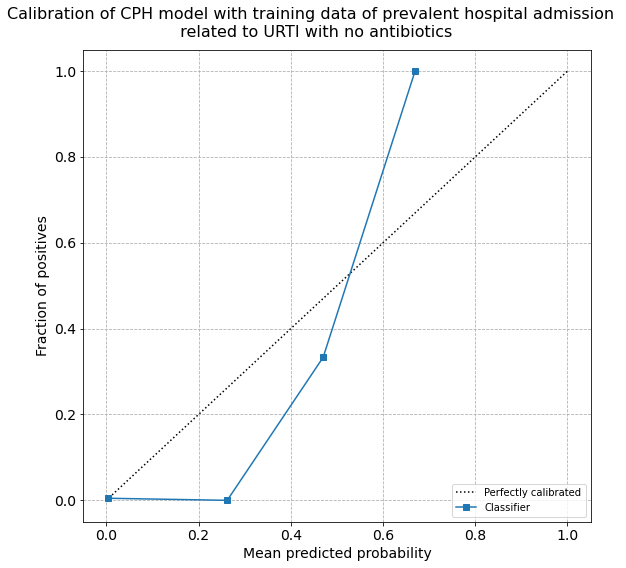

In [173]:
fig, axe = plt.subplots(figsize=(8, 8)
                        )

calib_cph_urti_no_abs_incdt_train = CalibrationDisplay.from_predictions(cph_urti_no_abs_prevl_train_cumulative_hazard.event_urti_admitted, cph_urti_no_abs_prevl_train_cumulative_hazard.cumulative_hazard, ax = axe)
plt.suptitle('Calibration of CPH model with training data of prevalent hospital admission \n related to URTI with no antibiotics', fontsize=16)
plt.xlabel('Mean predicted probability', fontsize=14)
plt.ylabel('Fraction of positives', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(visible=bool, linestyle='--')
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/calib_cph_urti_no_abs_prevl_train.jpg', bbox_inches='tight')
plt.show()

In [174]:
cph_urti_no_abs_prevl_test_cumulative_hazard.shape

(143, 2)

In [175]:
cph_urti_no_abs_prevl_test_cumulative_hazard.max()

cumulative_hazard      1681.396122
event_urti_admitted       0.000000
dtype: float64

In [341]:
# a = cph_urti_no_abs_prevl.predict_cumulative_hazard(data_urti_no_abs_prevl_train)
# a.loc[[188]]

In [176]:
cph_urti_no_abs_prevl_test_cumulative_hazard = cph_urti_no_abs_prevl_test_cumulative_hazard[cph_urti_no_abs_prevl_test_cumulative_hazard.cumulative_hazard <= 1]
cph_urti_no_abs_prevl_test_cumulative_hazard.max()

cumulative_hazard      0.61289
event_urti_admitted    0.00000
dtype: float64

In [177]:
cph_urti_no_abs_prevl_test_cumulative_hazard.shape

(139, 2)

In [350]:
fig, axe = plt.subplots(figsize=(8, 8)
                        )

calib_cph_urti_no_abs_incdt_test = CalibrationDisplay.from_predictions(cph_urti_no_abs_prevl_test_cumulative_hazard.event_urti_admitted, cph_urti_no_abs_prevl_test_cumulative_hazard.cumulative_hazard, ax = axe)
plt.suptitle('Calibration of CPH model with testing data of prevalent hospital admission \n related to URTI with no antibiotics', fontsize=16)
plt.xlabel('Mean predicted probability', fontsize=14)
plt.ylabel('Fraction of positives', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(visible=bool, linestyle='--')
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/calib_cph_urti_no_abs_prevl_test.jpg', bbox_inches='tight')
plt.show()

In [ ]:
# save model outputs
a = open("../output/hospitalisation_prediction_urti/cox_urti_no_abs_prevl_output.txt", "w")
a.write("")
a.writelines(['Concordance index for urti_no_abs_prevl with testing data: %.4f' % (concord_index_urti_no_abs_prevl_test), 
              '\nConcordance index for urti_no_abs_prevl with training data: %.4f' % (concord_index_urti_no_abs_prevl_train),
              '\nAUROC of CPH with training data of hospital admission related to prevalent URTI with no antibiotics = %.4f' % (r_auc1),
              '\nAUROC of CPH with testing data of hospital admission related to prevalent URTI with no antibiotics = %.4f' % (r_auc2),
              '\nBrier score of CPH with training data of hospital admission related to prevalent URTI with no antibiotics = %.4f' % (brier1),
              '\nBrier score of CPH with testing data of hospital admission related to prevalent URTI with no antibiotics = %.4f' % (brier2)])

#### 4-1-4- Prevalent hospital admission related to URTI with antibiotics

In [360]:
# data_urti_abs_prevl.columns

In [361]:
# #keep relevant variables
# data_urti_abs_prevl = data_urti_abs_prevl[['age_cat', 'sex', 'CCI_cat', 'age', 'bmi_imp', 'bmi_imp_cat', 
#                                            'gp_count_imp', 'gp_count_imp_cat', 'flu_vaccine', 'region_imp', 'season', 
#                                            'imd_imp', 'antibacterial_brit_imp', 'ethnicity_imp', 'antibacterial_brit_cat',
#                                            'smoking_status_imp', 'meds_nonabs', 'meds_nonabs_cat',
#                                            'event_urti_admitted', 'duration_urti_admitted']]

In [362]:
# # print number of missing values in each variable 
# data_urti_abs_prevl.isnull().sum()

In [363]:
# #randomly splitting data into training (%75) and testing (%25)
# data_urti_abs_prevl_train, data_urti_abs_prevl_test = train_test_split(data_urti_abs_prevl, test_size=0.2)

# print(f'shape of data_urti_abs_prevl for training: {data_urti_abs_prevl_train.shape}')
# print(f'shape of data_urti_abs_prevl for testing: {data_urti_abs_prevl_test.shape}')

In [364]:
# cph_urti_abs_prevl = CoxPHFitter().fit(data_urti_abs_prevl_train,
#         duration_col='duration_urti_admitted',
#         event_col='event_urti_admitted',
#         formula="age_cat + sex + CCI_cat + gp_count_imp_cat + flu_vaccine + bmi_imp_cat + region_imp + imd_imp + ethnicity_imp + smoking_status_imp + season"# + antibacterial_brit_imp + ethnicity_imp + smoking_status_imp + meds_nonabs" # season +
#         )
# cph_urti_abs_prevl.print_summary()

In [365]:
# output = GetPrintSummary(cph_urti_abs_prevl)

# with open('../output/hospitalisation_prediction_urti/cph_urti_abs_prevl_summary.html', "w") as fo:
#     print(fo.write(output))
#     fo.close()

In [366]:
# a = cph_urti_abs_prevl.baseline_hazard_

# # save 
# np.savetxt('../output/hospitalisation_prediction_urti/sum_betas_urti_abs_prevl.txt', a, delimiter=',')

In [367]:
# fig, ax = plt.subplots(figsize=(5, 9)
#                         )
# cph_urti_no_abs_prevl.plot()
# plt.suptitle('Coefficients of CPH model for prevalent hospital admission \n related to URTI with antibiotics', fontsize=16)
# #_ = ax.set_yticklabels(['Age', 'BMI', 'GP consultations', 'CCI', 'IMD', 'Flu vaccine', 'Antibacterial prescriptions'], 
# #                        rotation=45, fontsize=12, ha='right')
# plt.savefig('../output/hospitalisation_prediction_urti/coefficients_cph_urti_abs_prevl.jpg', bbox_inches='tight')
# plt.show()

In [368]:
# # concordance index of cph model with testing data
# concord_index_urti_abs_prevl_test = concordance_index(data_urti_abs_prevl_test['duration_urti_admitted'], -cph_urti_abs_prevl.predict_partial_hazard(data_urti_abs_prevl_test), data_urti_abs_prevl_test['event_urti_admitted'])
# print(f'Concordance index for cph_urti_abs_prevl with testing data: {concord_index_urti_abs_prevl_test}')

In [369]:
# a = [concord_index_urti_abs_prevl_test]
# np.savetxt('../output/hospitalisation_prediction_urti/concord_index_urti_abs_prevl_test.txt', a, delimiter=',')

In [370]:
# fig, ax = plt.subplots(figsize=(8, 5)
#                         )
# survival_probability_calibration(cph_urti_no_abs_prevl, data_urti_abs_prevl_train, t0=30)
# # plt.suptitle('Calibration of CPH model for prevalent hospital admission related to URTI with antibiotics', fontsize=16)
# plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_abs_prevl_train.jpg', bbox_inches='tight')
# plt.show()

In [ ]:
# fig, ax = plt.subplots(figsize=(8, 5)
#                         )
# survival_probability_calibration(cph_urti_no_abs_prevl, data_urti_abs_prevl_test, t0=30)
# plt.suptitle('Calibration of CPH model for prevalent hospital admission related to URTI with antibiotics', fontsize=16)
# plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_abs_prevl_test.jpg', bbox_inches='tight')
# plt.show()

## 5- Logistic regression
### 5-1- URTI
#### 5-1-1- Incident hospital admission related to URTI with no antibiotics

In [196]:
data_urti_no_abs_incdt.head()

,age_cat,sex,CCI_cat,age,bmi_imp,bmi_imp_cat,gp_count_imp,gp_count_imp_cat,flu_vaccine,region_imp,season,imd_imp,antibacterial_brit_imp,ethnicity_imp,antibacterial_brit_cat,smoking_status_imp,meds_nonabs,meds_nonabs_cat,event_urti_admitted,duration_urti_admitted
0,75+,Male,Low,6,0.000000,Underweight,0.0,Few,No,South West,Summer,5,2.0,Other,Some,Ex-smoker,0,Few,0.0,30.0
2,55-64,Female,Moderate,63,37.665590,Obese,5.0,Some,No,Yorkshire and The Humber,Autumn,1,1.0,White,Few,Ex-smoker,0,Few,0.0,30.0
3,65-74,Female,Low,38,39.949091,Obese,0.0,Few,No,London,Summer,5,0.0,Mixed,Few,Never smoked,0,Few,0.0,30.0
4,45-54,Female,High,0,36.318172,Obese,6.0,Some,No,London,Summer,1,0.0,White,Few,Ex-smoker,1,Few,0.0,30.0
5,65-74,Female,Very high,17,0.000000,Underweight,5.0,Some,No,Yorkshire and The Humber,Winter,5,0.0,Asian,Few,Smoker,0,Few,0.0,30.0


In [197]:
data_urti_no_abs_incdt.shape

(4913, 20)

In [198]:
# data_urti_no_abs_incdt.info()

In [199]:
# encoding categorical data for LR

# data = data_urti_abs_incdt[['event_urti_admitted', 'duration_urti_admitted', 'age', 'sex', 'CCI_cat', 'bmi_imp', 'bmi_imp_cat', 'gp_count_imp', 'gp_count_imp_cat', 'region_imp', 'season', 'imd_imp', 'ethnicity_imp', 'antibacterial_brit_imp', 'antibacterial_brit_cat', 'smoking_status_imp', 'meds_nonabs', 'meds_nonabs_cat']].reset_index()
data = data_urti_no_abs_incdt[['sex', 'CCI_cat', 'bmi_imp_cat', 'gp_count_imp_cat', 'region_imp', 'season', 'imd_imp', 'ethnicity_imp', 'antibacterial_brit_cat', 'smoking_status_imp', 'meds_nonabs_cat']].reset_index()
# data

# creating instance of one-hot-encoder
enc = OneHotEncoder()
results = enc.fit_transform(data)
# passing bridge-types-cat column (label encoded values of bridge_types)
data_urti_no_abs_incdt_enc = pd.DataFrame(enc.fit_transform(data[['sex', 'CCI_cat', 'bmi_imp_cat', 'gp_count_imp_cat', 'region_imp', 'season', 'imd_imp', 'ethnicity_imp', 'antibacterial_brit_cat', 'smoking_status_imp', 'meds_nonabs_cat']]).toarray())
data_urti_no_abs_incdt_enc.columns = enc.get_feature_names(data[['sex', 'CCI_cat', 'bmi_imp_cat', 'gp_count_imp_cat', 'region_imp', 'season', 'imd_imp', 'ethnicity_imp', 'antibacterial_brit_cat', 'smoking_status_imp', 'meds_nonabs_cat']].columns)
# data_urti_abs_incdt_enc = data.join(data_urti_abs_incdt_enc)
# data_urti_abs_incdt_enc = data_urti_abs_incdt_enc.drop(columns=['index', ])

data_urti_no_abs_incdt_enc.head()

,sex_Female,sex_Male,CCI_cat_High,CCI_cat_Low,CCI_cat_Moderate,CCI_cat_No,CCI_cat_Very high,bmi_imp_cat_Healthy weight,bmi_imp_cat_Obese,bmi_imp_cat_Overweight,...,ethnicity_imp_Other,ethnicity_imp_White,antibacterial_brit_cat_Few,antibacterial_brit_cat_Many,antibacterial_brit_cat_Some,smoking_status_imp_Ex-smoker,smoking_status_imp_Never smoked,smoking_status_imp_Smoker,meds_nonabs_cat_Few,meds_nonabs_cat_Some
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [200]:
data_urti_no_abs_incdt_enc.shape

(4913, 45)

In [201]:
data_urti_no_abs_incdt_enc.columns

Index(['sex_Female', 'sex_Male', 'CCI_cat_High', 'CCI_cat_Low',
       'CCI_cat_Moderate', 'CCI_cat_No', 'CCI_cat_Very high',
       'bmi_imp_cat_Healthy weight', 'bmi_imp_cat_Obese',
       'bmi_imp_cat_Overweight', 'bmi_imp_cat_Underweight',
       'gp_count_imp_cat_Few', 'gp_count_imp_cat_Many',
       'gp_count_imp_cat_Some', 'region_imp_East', 'region_imp_East Midlands',
       'region_imp_London', 'region_imp_North East', 'region_imp_North West',
       'region_imp_South East', 'region_imp_South West',
       'region_imp_West Midlands', 'region_imp_Yorkshire and The Humber',
       'season_Autumn', 'season_Spring', 'season_Summer', 'season_Winter',
       'imd_imp_0', 'imd_imp_1', 'imd_imp_2', 'imd_imp_3', 'imd_imp_4',
       'imd_imp_5', 'ethnicity_imp_Asian', 'ethnicity_imp_Mixed',
       'ethnicity_imp_Other', 'ethnicity_imp_White',
       'antibacterial_brit_cat_Few', 'antibacterial_brit_cat_Many',
       'antibacterial_brit_cat_Some', 'smoking_status_imp_Ex-smoker',
       '

In [202]:
#randomly splitting data into training (%75) and testing (%25)
data_urti_no_abs_incdt_lr_X_train, data_urti_no_abs_incdt_lr_X_test, data_urti_no_abs_incdt_lr_y_train, data_urti_no_abs_incdt_lr_y_test = train_test_split(data_urti_no_abs_incdt_enc, data_urti_no_abs_incdt.event_urti_admitted, test_size=0.25, random_state=42)

print(f'shape of data_urti_no_abs_incdt_lr_X for training: {data_urti_no_abs_incdt_lr_X_train.shape}')
print(f'shape of data_urti_no_abs_incdt_lr_X for testing: {data_urti_no_abs_incdt_lr_X_test.shape}')
print(f'shape of data_urti_no_abs_incdt_lr_y for training: {data_urti_no_abs_incdt_lr_y_train.shape}')
print(f'shape of data_urti_no_abs_incdt_lr_y for testing: {data_urti_no_abs_incdt_lr_y_test.shape}')

shape of data_urti_no_abs_incdt_lr_X for training: (3684, 45)
shape of data_urti_no_abs_incdt_lr_X for testing: (1229, 45)
shape of data_urti_no_abs_incdt_lr_y for training: (3684,)
shape of data_urti_no_abs_incdt_lr_y for testing: (1229,)


In [203]:
#build LR model
lr_urti_no_abs_incdt = LogisticRegression().fit(data_urti_no_abs_incdt_lr_X_train, data_urti_no_abs_incdt_lr_y_train)

#prediction of hsopital admission related to urti of training data using lr
pred_proba_urti_no_abs_incdt_train = lr_urti_no_abs_incdt.predict_proba(data_urti_no_abs_incdt_lr_X_train)
# pred_proba_urti_no_abs_incdt_train

#calculate score of lr_urti_no_abs_incdt with training data
lr_urti_no_abs_incdt_training_score = lr_urti_no_abs_incdt.score(data_urti_no_abs_incdt_lr_X_train, data_urti_no_abs_incdt_lr_y_train)
print(f'score of lr_urti_no_abs_incdt with training data: {lr_urti_no_abs_incdt_training_score}')

#prediction of hsopital admission related to urti of testing data using lr
pred_proba_urti_no_abs_incdt_test = lr_urti_no_abs_incdt.predict_proba(data_urti_no_abs_incdt_lr_X_test)
# pred_proba_urti_no_abs_incdt_test

#calculate score of lr_urti_no_abs_incdt with testing data
lr_urti_no_abs_incdt_testing_score = lr_urti_no_abs_incdt.score(data_urti_no_abs_incdt_lr_X_test, data_urti_no_abs_incdt_lr_y_test)
print(f'score of lr_urti_no_abs_incdt with testing data: {lr_urti_no_abs_incdt_testing_score}')


score of lr_urti_no_abs_incdt with training data: 0.992399565689468
score of lr_urti_no_abs_incdt with testing data: 0.9902359641985354


In [204]:
data_urti_no_abs_incdt_lr_X_test.shape

(1229, 45)

In [205]:
data_urti_no_abs_incdt_enc

,sex_Female,sex_Male,CCI_cat_High,CCI_cat_Low,CCI_cat_Moderate,CCI_cat_No,CCI_cat_Very high,bmi_imp_cat_Healthy weight,bmi_imp_cat_Obese,bmi_imp_cat_Overweight,...,ethnicity_imp_Other,ethnicity_imp_White,antibacterial_brit_cat_Few,antibacterial_brit_cat_Many,antibacterial_brit_cat_Some,smoking_status_imp_Ex-smoker,smoking_status_imp_Never smoked,smoking_status_imp_Smoker,meds_nonabs_cat_Few,meds_nonabs_cat_Some
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4908,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4909,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
4910,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
4911,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0


In [192]:
lr_urti_no_abs_incdt.decision_function(data_urti_no_abs_incdt_enc)

array([-6.83220444, -4.20788516, -7.99122513, ..., -5.93898527,
       -5.41622006, -6.33928963])

In [206]:
lr_urti_no_abs_incdt.coef_

array([[-0.12762523,  0.12800861, -0.10191773, -0.37777972,  0.76211367,
         0.69075102, -0.97278385, -0.38811037,  0.03670525,  0.2139294 ,
         0.13785911, -0.03355187,  0.22792632, -0.19399107,  0.43738597,
        -0.48462504,  0.13403365,  0.72513714, -0.44095986, -0.18810246,
        -0.92987757,  0.11783014,  0.62956141,  0.1721729 ,  0.06597192,
        -0.16690089, -0.07086055, -0.10666891,  0.1763076 ,  0.51389021,
        -0.17073849, -0.18758469, -0.22482233,  0.20232468, -0.00338804,
        -0.2953706 ,  0.09681735, -0.55565172,  0.42150893,  0.13452617,
         0.51989599, -0.94805289,  0.42854028, -0.32398777,  0.32437115]])

In [207]:
lr_urti_no_abs_incdt.feature_names_in_

array(['sex_Female', 'sex_Male', 'CCI_cat_High', 'CCI_cat_Low',
       'CCI_cat_Moderate', 'CCI_cat_No', 'CCI_cat_Very high',
       'bmi_imp_cat_Healthy weight', 'bmi_imp_cat_Obese',
       'bmi_imp_cat_Overweight', 'bmi_imp_cat_Underweight',
       'gp_count_imp_cat_Few', 'gp_count_imp_cat_Many',
       'gp_count_imp_cat_Some', 'region_imp_East',
       'region_imp_East Midlands', 'region_imp_London',
       'region_imp_North East', 'region_imp_North West',
       'region_imp_South East', 'region_imp_South West',
       'region_imp_West Midlands', 'region_imp_Yorkshire and The Humber',
       'season_Autumn', 'season_Spring', 'season_Summer', 'season_Winter',
       'imd_imp_0', 'imd_imp_1', 'imd_imp_2', 'imd_imp_3', 'imd_imp_4',
       'imd_imp_5', 'ethnicity_imp_Asian', 'ethnicity_imp_Mixed',
       'ethnicity_imp_Other', 'ethnicity_imp_White',
       'antibacterial_brit_cat_Few', 'antibacterial_brit_cat_Many',
       'antibacterial_brit_cat_Some', 'smoking_status_imp_Ex-smoker',
 

In [209]:
feature_names = lr_urti_no_abs_incdt.feature_names_in_
coef = np.squeeze(lr_urti_no_abs_incdt.coef_)

coef_lr = pd.DataFrame({'Coefficients':coef}, index = feature_names)
coef_lr = coef_lr.Coefficients.sort_values()
# coef_lr

# save 
np.savetxt('../output/hospitalisation_prediction_urti/coef_urti_no_abs_incdt.txt', coef_lr, delimiter=',')

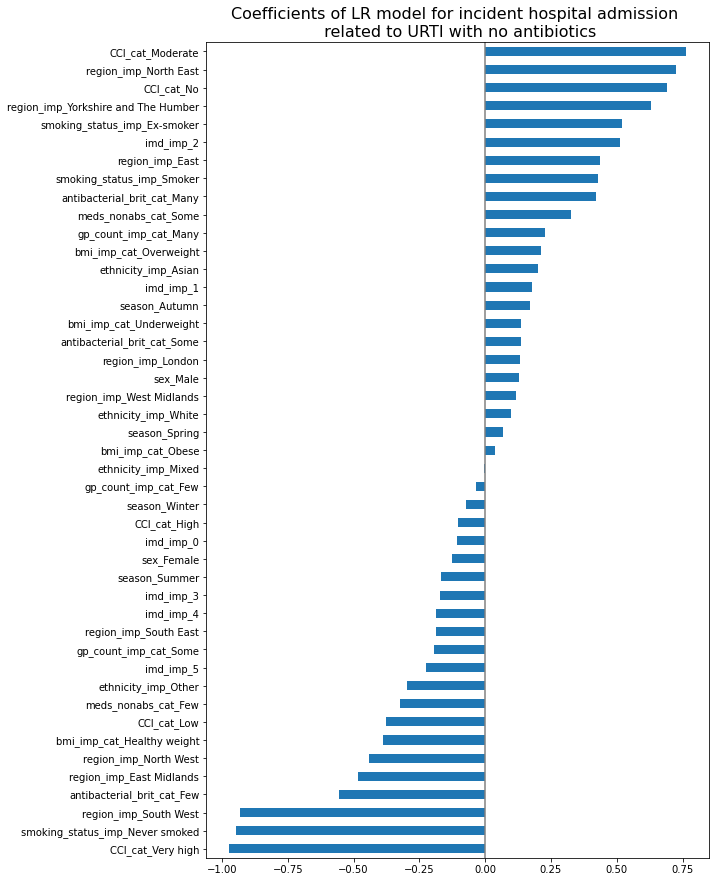

In [210]:
# feature_names = lr_urti_no_abs_incdt.feature_names_in_
# coef = np.squeeze(lr_urti_no_abs_incdt.coef_)

# coef_lr = pd.DataFrame({'Coefficients':coef}, index = feature_names)
# coef_lr = coef_lr.Coefficients.sort_values()
# # coef_lr

coef_lr.plot(kind="barh", figsize=(9, 15))
plt.title('Coefficients of LR model for incident hospital admission \n related to URTI with no antibiotics', fontsize=16)
plt.axvline(x=0, color=".5")
# plt.subplots_adjust(left=0.3)
# plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/coef_lr_urti_no_abs_incdt.jpg', bbox_inches='tight')
plt.show()

In [211]:
a = lr_urti_no_abs_incdt.intercept_

# save 
np.savetxt('../output/hospitalisation_prediction_urti/intercept_urti_no_abs_incdt.txt', a, delimiter=',')

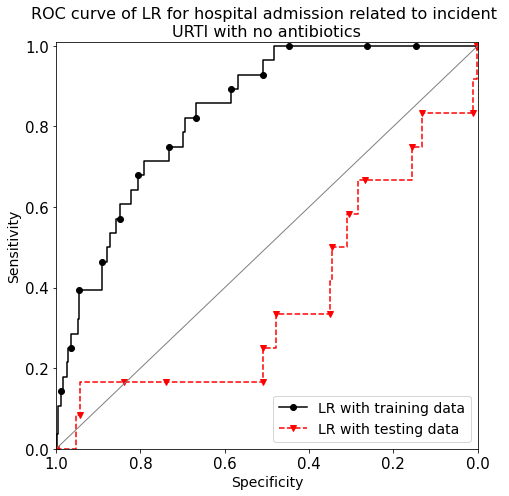

In [212]:
r_fpr1, r_tpr1, _ = roc_curve(data_urti_no_abs_incdt_lr_y_train, pred_proba_urti_no_abs_incdt_train[:,1])
r_fpr2, r_tpr2, _ = roc_curve(data_urti_no_abs_incdt_lr_y_test, pred_proba_urti_no_abs_incdt_test[:,1])

fig, ax1 = pyplot.subplots(figsize=(7, 7))

line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='LR with training data')
line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='LR with testing data')


squares = [0,1]
plt.plot(squares,linewidth=1, color='grey')
plt.ylim(0,1.01)
plt.xlim(0,1)

#plt.title('ROC Curve')
plt.xlabel('Specificity', fontsize=14)
plt.ylabel('Sensitivity', fontsize=14)

#reversing xticks
xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
x = np.arange(len(xticks))
ax1.set(xticklabels=xticks)
ax1.legend(fontsize=14)
plt.title('ROC curve of LR for hospital admission related to incident \nURTI with no antibiotics', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15, rotation=0)
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/roc_lr_urti_no_abs_incdt.jpg', bbox_inches='tight')
plt.show()

In [213]:
r_auc1 = roc_auc_score(data_urti_no_abs_incdt_lr_y_train, pred_proba_urti_no_abs_incdt_train[:,1])
r_auc2 = roc_auc_score(data_urti_no_abs_incdt_lr_y_test, pred_proba_urti_no_abs_incdt_test[:,1])
brier1 = brier_score_loss(data_urti_no_abs_incdt_lr_y_train, pred_proba_urti_no_abs_incdt_train[:,1])
brier2 = brier_score_loss(data_urti_no_abs_incdt_lr_y_test, pred_proba_urti_no_abs_incdt_test[:,1])

print('AUROC of LR with training data of hospital admission related to incident URTI with no antibiotics = %.4f' % (r_auc1))
print('AUROC of LR with testing data of hospital admission related to incident URTI with no antibiotics = %.4f' % (r_auc2))
print('Brier score of LR with training data of hospital admission related to incident URTI with no antibiotics = %.4f' % (brier1))
print('Brier score of LR with testing data of hospital admission related to incident URTI with no antibiotics = %.4f' % (brier2))

AUROC of LR with training data of hospital admission related to incident URTI with no antibiotics = 0.8326
AUROC of LR with testing data of hospital admission related to incident URTI with no antibiotics = 0.3732
Brier score of LR with training data of hospital admission related to incident URTI with no antibiotics = 0.0074
Brier score of LR with testing data of hospital admission related to incident URTI with no antibiotics = 0.0098


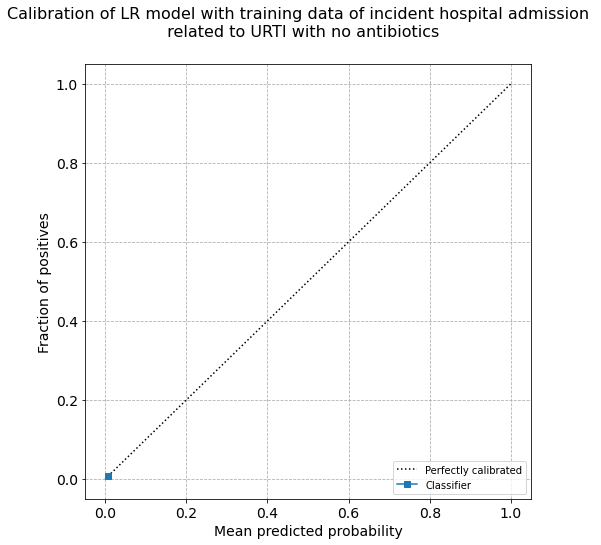

In [214]:
fig, axe = plt.subplots(figsize=(8, 8)
                        )

calib_lr_urti_no_abs_incdt_train = CalibrationDisplay.from_predictions(data_urti_no_abs_incdt_lr_y_train, pred_proba_urti_no_abs_incdt_train[:,1], ax = axe)
plt.suptitle('Calibration of LR model with training data of incident hospital admission \n related to URTI with no antibiotics', fontsize=16)
plt.xlabel('Mean predicted probability', fontsize=14)
plt.ylabel('Fraction of positives', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(visible=bool, linestyle='--')
# plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/calib_lr_urti_no_abs_incdt_train.jpg', bbox_inches='tight')
plt.show()

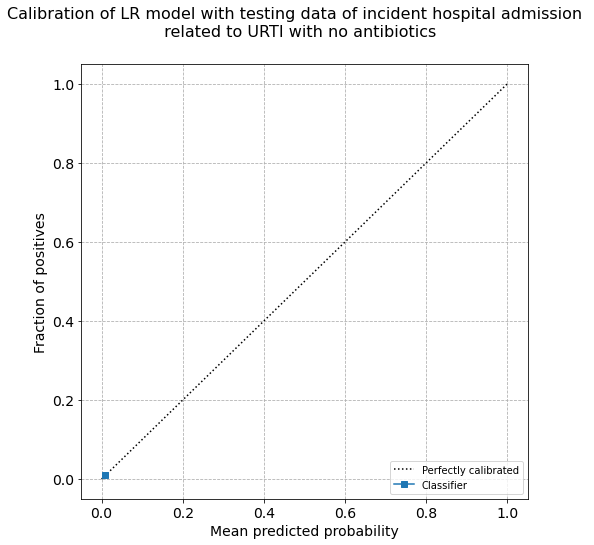

In [215]:
fig, axe = plt.subplots(figsize=(8, 8)
                        )

calib_lr_urti_no_abs_incdt_train = CalibrationDisplay.from_predictions(data_urti_no_abs_incdt_lr_y_test, pred_proba_urti_no_abs_incdt_test[:,1], ax = axe)
plt.suptitle('Calibration of LR model with testing data of incident hospital admission \n related to URTI with no antibiotics', fontsize=16)
plt.xlabel('Mean predicted probability', fontsize=14)
plt.ylabel('Fraction of positives', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(visible=bool, linestyle='--')
# plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/calib_lr_urti_no_abs_incdt_test.jpg', bbox_inches='tight')
plt.show()

In [216]:
# save model outputs
a = open("../output/hospitalisation_prediction_urti/lr_urti_no_abs_incdt_output.txt", "w")
a.write("")
a.writelines(['AUROC of LR with training data of hospital admission related to incident URTI with no antibiotics = %.4f' % (r_auc1),
              '\nAUROC of LR with testing data of hospital admission related to incident URTI with no antibiotics = %.4f' % (r_auc2),
              '\nBrier score of LR with training data of hospital admission related to incident URTI with no antibiotics = %.4f' % (brier1),
              '\nBrier score of LR with testing data of hospital admission related to incident URTI with no antibiotics = %.4f' % (brier2)])

### 5-1-2- Incident hospital admission related to URTI with antibiotics

In [217]:
data_urti_abs_incdt.head()

,age_cat,sex,CCI_cat,age,bmi_imp,bmi_imp_cat,gp_count_imp,gp_count_imp_cat,flu_vaccine,region_imp,season,imd_imp,antibacterial_brit_imp,ethnicity_imp,antibacterial_brit_cat,smoking_status_imp,meds_nonabs,meds_nonabs_cat,event_urti_admitted,duration_urti_admitted
1,45-54,Male,Low,58,34.57354,Obese,4.0,Some,No,West Midlands,Summer,1,0.0,Mixed,Few,Ex-smoker,2,Some,0.0,30.0
7,35-44,Male,No,84,0.00000,Underweight,0.0,Few,No,South East,Autumn,2,2.0,White,Some,Smoker,0,Few,0.0,30.0
10,25-34,Male,High,54,0.00000,Underweight,3.0,Some,No,South West,Summer,5,0.0,Other,Few,Ex-smoker,2,Some,0.0,30.0
16,15-24,Male,No,9,29.38802,Overweight,12.0,Many,No,North West,Winter,3,0.0,Mixed,Few,Ex-smoker,0,Few,0.0,30.0
19,55-64,Male,Low,60,0.00000,Underweight,5.0,Some,No,South West,Winter,4,0.0,White,Few,Ex-smoker,0,Few,0.0,30.0


In [218]:
data_urti_abs_incdt.shape

(537, 20)

In [219]:
# encoding categorical data for LR

data = data_urti_abs_incdt[['sex', 'CCI_cat', 'bmi_imp_cat', 'gp_count_imp_cat', 'region_imp', 'season', 'imd_imp', 'ethnicity_imp', 'antibacterial_brit_cat', 'smoking_status_imp', 'meds_nonabs_cat']].reset_index()
# data

# creating instance of one-hot-encoder
enc = OneHotEncoder()
results = enc.fit_transform(data)
# passing bridge-types-cat column (label encoded values of bridge_types)
data_urti_abs_incdt_enc = pd.DataFrame(enc.fit_transform(data[['sex', 'CCI_cat', 'bmi_imp_cat', 'gp_count_imp_cat', 'region_imp', 'season', 'imd_imp', 'ethnicity_imp', 'antibacterial_brit_cat', 'smoking_status_imp', 'meds_nonabs_cat']]).toarray())
data_urti_abs_incdt_enc.columns = enc.get_feature_names(data[['sex', 'CCI_cat', 'bmi_imp_cat', 'gp_count_imp_cat', 'region_imp', 'season', 'imd_imp', 'ethnicity_imp', 'antibacterial_brit_cat', 'smoking_status_imp', 'meds_nonabs_cat']].columns)
# data_urti_abs_incdt_enc = data.join(data_urti_abs_incdt_enc)
# data_urti_abs_incdt_enc = data_urti_abs_incdt_enc.drop(columns=['index', ])

data_urti_abs_incdt_enc.head()

,sex_Female,sex_Male,CCI_cat_High,CCI_cat_Low,CCI_cat_Moderate,CCI_cat_No,CCI_cat_Very high,bmi_imp_cat_Healthy weight,bmi_imp_cat_Obese,bmi_imp_cat_Overweight,...,ethnicity_imp_White,antibacterial_brit_cat_Few,antibacterial_brit_cat_Many,antibacterial_brit_cat_Some,smoking_status_imp_Ex-smoker,smoking_status_imp_Never smoked,smoking_status_imp_Smoker,meds_nonabs_cat_Few,meds_nonabs_cat_Many,meds_nonabs_cat_Some
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [220]:
data_urti_abs_incdt_enc.columns

Index(['sex_Female', 'sex_Male', 'CCI_cat_High', 'CCI_cat_Low',
       'CCI_cat_Moderate', 'CCI_cat_No', 'CCI_cat_Very high',
       'bmi_imp_cat_Healthy weight', 'bmi_imp_cat_Obese',
       'bmi_imp_cat_Overweight', 'bmi_imp_cat_Underweight',
       'gp_count_imp_cat_Few', 'gp_count_imp_cat_Many',
       'gp_count_imp_cat_Some', 'region_imp_East', 'region_imp_East Midlands',
       'region_imp_London', 'region_imp_North East', 'region_imp_North West',
       'region_imp_South East', 'region_imp_South West',
       'region_imp_West Midlands', 'region_imp_Yorkshire and The Humber',
       'season_Autumn', 'season_Spring', 'season_Summer', 'season_Winter',
       'imd_imp_0', 'imd_imp_1', 'imd_imp_2', 'imd_imp_3', 'imd_imp_4',
       'imd_imp_5', 'ethnicity_imp_Asian', 'ethnicity_imp_Mixed',
       'ethnicity_imp_Other', 'ethnicity_imp_White',
       'antibacterial_brit_cat_Few', 'antibacterial_brit_cat_Many',
       'antibacterial_brit_cat_Some', 'smoking_status_imp_Ex-smoker',
       '

In [221]:
#randomly splitting data into training (%75) and testing (%25)
data_urti_abs_incdt_lr_X_train, data_urti_abs_incdt_lr_X_test, data_urti_abs_incdt_lr_y_train, data_urti_abs_incdt_lr_y_test = train_test_split(data_urti_abs_incdt_enc, data_urti_abs_incdt.event_urti_admitted, test_size=0.25, random_state=42)

print(f'shape of data_urti_abs_incdt_lr_X for training: {data_urti_abs_incdt_lr_X_train.shape}')
print(f'shape of data_urti_abs_incdt_lr_X for testing: {data_urti_abs_incdt_lr_X_test.shape}')
print(f'shape of data_urti_abs_incdt_lr_y for training: {data_urti_abs_incdt_lr_y_train.shape}')
print(f'shape of data_urti_abs_incdt_lr_y for testing: {data_urti_abs_incdt_lr_y_test.shape}')

shape of data_urti_abs_incdt_lr_X for training: (402, 46)
shape of data_urti_abs_incdt_lr_X for testing: (135, 46)
shape of data_urti_abs_incdt_lr_y for training: (402,)
shape of data_urti_abs_incdt_lr_y for testing: (135,)


In [222]:
#build LR model
lr_urti_abs_incdt = LogisticRegression().fit(data_urti_abs_incdt_lr_X_train, data_urti_abs_incdt_lr_y_train)

#prediction of hsopital admission related to urti of training data using lr
pred_proba_urti_abs_incdt_train = lr_urti_abs_incdt.predict_proba(data_urti_abs_incdt_lr_X_train)
# pred_proba_urti_abs_incdt_train

#calculate score of lr_urti_abs_incdt with training data
lr_urti_abs_incdt_training_score = lr_urti_abs_incdt.score(data_urti_abs_incdt_lr_X_train, data_urti_abs_incdt_lr_y_train)
print(f'score of lr_urti_abs_incdt with training data: {lr_urti_abs_incdt_training_score}')

#prediction of hsopital admission related to urti of testing data using lr
pred_proba_urti_abs_incdt_test = lr_urti_abs_incdt.predict_proba(data_urti_abs_incdt_lr_X_test)
# pred_proba_urti_abs_incdt_test

#calculate score of lr_urti_abs_incdt with testing data
lr_urti_abs_incdt_testing_score = lr_urti_abs_incdt.score(data_urti_abs_incdt_lr_X_test, data_urti_abs_incdt_lr_y_test)
print(f'score of lr_urti_abs_incdt with testing data: {lr_urti_abs_incdt_testing_score}')

score of lr_urti_abs_incdt with training data: 0.9925373134328358
score of lr_urti_abs_incdt with testing data: 0.9925925925925926


In [223]:
lr_urti_abs_incdt.coef_

array([[ 0.07662853, -0.07662381, -0.24450303, -0.03230131,  0.86069948,
        -0.41468183, -0.1692086 , -0.13518227,  0.14390758, -0.23911508,
         0.23039448,  0.21660196, -0.2909476 ,  0.07435035,  0.4462372 ,
        -0.22588859, -0.30521304,  0.55323188, -0.23588582,  0.55458278,
        -0.39021208, -0.21035635, -0.18649127, -0.39412905,  0.66076795,
        -0.40422941,  0.13759522, -0.09723108,  0.31581267,  0.16972399,
        -0.40259917,  0.36128013, -0.34698183,  0.43732125,  0.19075714,
        -0.29180812, -0.33626556,  0.54198708, -0.14342998, -0.39855238,
         0.77722109, -0.20133408, -0.57588229,  0.0126315 , -0.04562619,
         0.0329994 ]])

In [224]:
lr_urti_abs_incdt.feature_names_in_

array(['sex_Female', 'sex_Male', 'CCI_cat_High', 'CCI_cat_Low',
       'CCI_cat_Moderate', 'CCI_cat_No', 'CCI_cat_Very high',
       'bmi_imp_cat_Healthy weight', 'bmi_imp_cat_Obese',
       'bmi_imp_cat_Overweight', 'bmi_imp_cat_Underweight',
       'gp_count_imp_cat_Few', 'gp_count_imp_cat_Many',
       'gp_count_imp_cat_Some', 'region_imp_East',
       'region_imp_East Midlands', 'region_imp_London',
       'region_imp_North East', 'region_imp_North West',
       'region_imp_South East', 'region_imp_South West',
       'region_imp_West Midlands', 'region_imp_Yorkshire and The Humber',
       'season_Autumn', 'season_Spring', 'season_Summer', 'season_Winter',
       'imd_imp_0', 'imd_imp_1', 'imd_imp_2', 'imd_imp_3', 'imd_imp_4',
       'imd_imp_5', 'ethnicity_imp_Asian', 'ethnicity_imp_Mixed',
       'ethnicity_imp_Other', 'ethnicity_imp_White',
       'antibacterial_brit_cat_Few', 'antibacterial_brit_cat_Many',
       'antibacterial_brit_cat_Some', 'smoking_status_imp_Ex-smoker',
 

In [225]:
feature_names = lr_urti_abs_incdt.feature_names_in_
coef = np.squeeze(lr_urti_abs_incdt.coef_)

coef_lr = pd.DataFrame({'Coefficients':coef}, index = feature_names)
coef_lr = coef_lr.Coefficients.sort_values()
# coef_lr

# save 
np.savetxt('../output/hospitalisation_prediction_urti/coef_urti_abs_incdt.txt', coef_lr, delimiter=',')

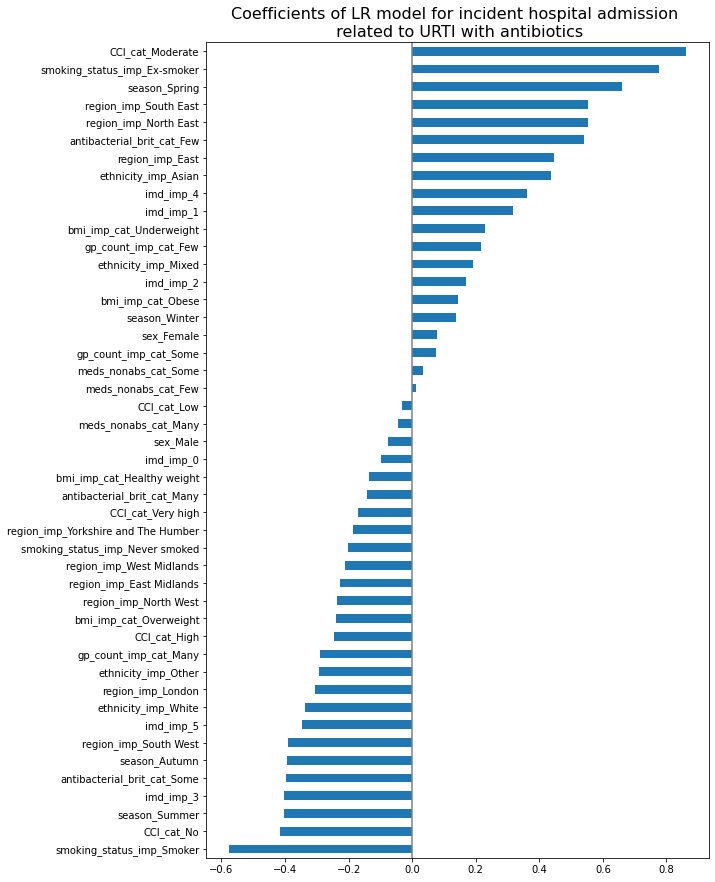

In [226]:
coef_lr.plot(kind="barh", figsize=(9, 15))
plt.title('Coefficients of LR model for incident hospital admission \n related to URTI with antibiotics', fontsize=16)
plt.axvline(x=0, color=".5")
# plt.subplots_adjust(left=0.3)
# plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/coef_lr_urti_abs_incdt.jpg', bbox_inches='tight')
plt.show()

In [227]:
a = lr_urti_abs_incdt.intercept_

# save 
np.savetxt('../output/hospitalisation_prediction_urti/intercept_urti_abs_incdt.txt', a, delimiter=',')

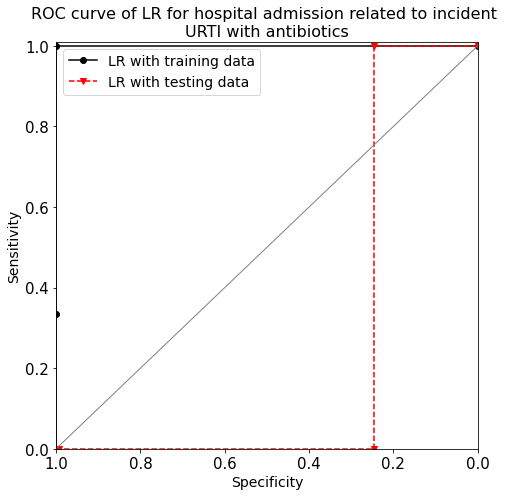

In [228]:
r_fpr1, r_tpr1, _ = roc_curve(data_urti_abs_incdt_lr_y_train, pred_proba_urti_abs_incdt_train[:,1])
r_fpr2, r_tpr2, _ = roc_curve(data_urti_abs_incdt_lr_y_test, pred_proba_urti_abs_incdt_test[:,1])

fig, ax1 = pyplot.subplots(figsize=(7, 7))

line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='LR with training data')
line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='LR with testing data')


squares = [0,1]
plt.plot(squares,linewidth=1, color='grey')
plt.ylim(0,1.01)
plt.xlim(0,1)

#plt.title('ROC Curve')
plt.xlabel('Specificity', fontsize=14)
plt.ylabel('Sensitivity', fontsize=14)

#reversing xticks
xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
x = np.arange(len(xticks))
ax1.set(xticklabels=xticks)
ax1.legend(fontsize=14)
plt.title('ROC curve of LR for hospital admission related to incident \nURTI with antibiotics', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15, rotation=0)
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/roc_lr_urti_abs_incdt.jpg', bbox_inches='tight')
plt.show()

In [229]:
r_auc1 = roc_auc_score(data_urti_abs_incdt_lr_y_train, pred_proba_urti_abs_incdt_train[:,1])
r_auc2 = roc_auc_score(data_urti_abs_incdt_lr_y_test, pred_proba_urti_abs_incdt_test[:,1])
brier1 = brier_score_loss(data_urti_abs_incdt_lr_y_train, pred_proba_urti_abs_incdt_train[:,1])
brier2 = brier_score_loss(data_urti_abs_incdt_lr_y_test, pred_proba_urti_abs_incdt_test[:,1])

print('AUROC of LR with training data of hospital admission related to incident URTI with antibiotics = %.4f' % (r_auc1))
print('AUROC of LR with testing data of hospital admission related to incident URTI with antibiotics = %.4f' % (r_auc2))
print('Brier score of LR with training data of hospital admission related to incident URTI with antibiotics = %.4f' % (brier1))
print('Brier score of LR with testing data of hospital admission related to incident URTI with antibiotics = %.4f' % (brier2))

AUROC of LR with training data of hospital admission related to incident URTI with antibiotics = 1.0000
AUROC of LR with testing data of hospital admission related to incident URTI with antibiotics = 0.2463
Brier score of LR with training data of hospital admission related to incident URTI with antibiotics = 0.0063
Brier score of LR with testing data of hospital admission related to incident URTI with antibiotics = 0.0076


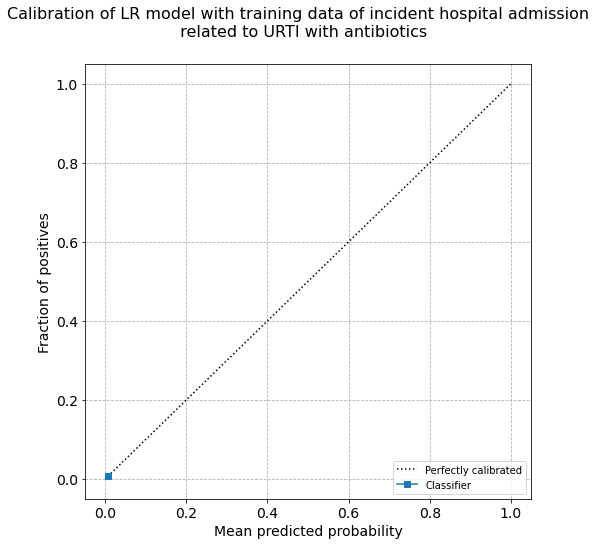

In [230]:
fig, axe = plt.subplots(figsize=(8, 8)
                        )

calib_lr_urti_abs_incdt_train = CalibrationDisplay.from_predictions(data_urti_abs_incdt_lr_y_train, pred_proba_urti_abs_incdt_train[:,1], ax = axe)
plt.suptitle('Calibration of LR model with training data of incident hospital admission \n related to URTI with antibiotics', fontsize=16)
plt.xlabel('Mean predicted probability', fontsize=14)
plt.ylabel('Fraction of positives', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(visible=bool, linestyle='--')
# plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/calib_lr_urti_abs_incdt_train.jpg', bbox_inches='tight')
plt.show()

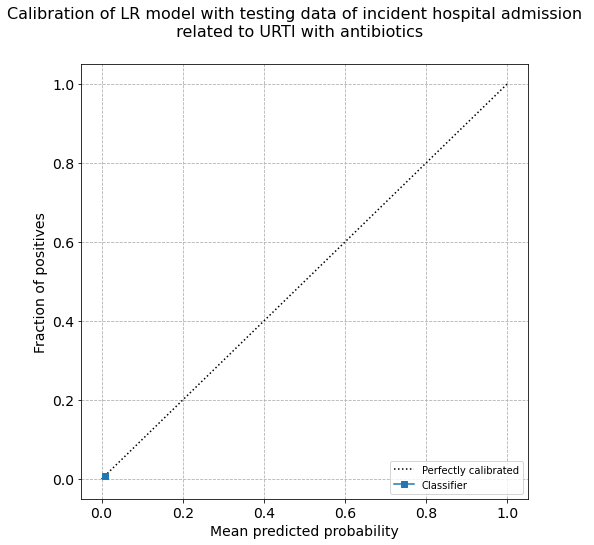

In [231]:
fig, axe = plt.subplots(figsize=(8, 8)
                        )

calib_lr_urti_abs_incdt_train = CalibrationDisplay.from_predictions(data_urti_abs_incdt_lr_y_test, pred_proba_urti_abs_incdt_test[:,1], ax = axe)
plt.suptitle('Calibration of LR model with testing data of incident hospital admission \n related to URTI with antibiotics', fontsize=16)
plt.xlabel('Mean predicted probability', fontsize=14)
plt.ylabel('Fraction of positives', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(visible=bool, linestyle='--')
# plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/calib_lr_urti_abs_incdt_test.jpg', bbox_inches='tight')
plt.show()

In [232]:
# save model outputs
a = open("../output/hospitalisation_prediction_urti/lr_urti_abs_incdt_output.txt", "w")
a.write("")
a.writelines(['AUROC of LR with training data of hospital admission related to incident URTI with antibiotics = %.4f' % (r_auc1),
              '\nAUROC of LR with testing data of hospital admission related to incident URTI with antibiotics = %.4f' % (r_auc2),
              '\nBrier score of LR with training data of hospital admission related to incident URTI with antibiotics = %.4f' % (brier1),
              '\nBrier score of LR with testing data of hospital admission related to incident URTI with antibiotics = %.4f' % (brier2)])

### 5-1-3- Prevalent hospital admission related to URTI with no antibiotics

In [233]:
data_urti_no_abs_prevl.head()

,age_cat,sex,CCI_cat,age,bmi_imp,bmi_imp_cat,gp_count_imp,gp_count_imp_cat,flu_vaccine,region_imp,season,imd_imp,antibacterial_brit_imp,ethnicity_imp,antibacterial_brit_cat,smoking_status_imp,meds_nonabs,meds_nonabs_cat,event_urti_admitted,duration_urti_admitted
9,65-74,Female,Very high,45,30.777512,Obese,9.0,Many,No,London,Summer,0,0.0,White,Few,Ex-smoker,3,Some,0.0,30.0
21,55-64,Female,Low,79,43.888476,Obese,1.0,Few,No,East Midlands,Summer,1,0.0,White,Few,Ex-smoker,0,Few,0.0,30.0
27,0-4,Male,High,47,0.000000,Underweight,2.0,Few,No,East,Winter,5,2.0,White,Some,Never smoked,1,Few,0.0,30.0
55,45-54,Male,Low,41,0.000000,Underweight,0.0,Few,No,North East,Spring,5,0.0,Mixed,Few,Ex-smoker,3,Some,0.0,30.0
64,65-74,Male,Low,45,53.155445,Obese,11.0,Many,No,London,Summer,5,3.0,White,Some,Ex-smoker,0,Few,0.0,30.0


In [234]:
data_urti_no_abs_prevl.shape

(557, 20)

In [235]:
# encoding categorical data for LR

data = data_urti_no_abs_prevl[['sex', 'CCI_cat', 'bmi_imp_cat', 'gp_count_imp_cat', 'region_imp', 'season', 'imd_imp', 'ethnicity_imp', 'antibacterial_brit_cat', 'smoking_status_imp', 'meds_nonabs_cat']].reset_index()
# data

# creating instance of one-hot-encoder
enc = OneHotEncoder()
results = enc.fit_transform(data)
# passing bridge-types-cat column (label encoded values of bridge_types)
data_urti_no_abs_prevl_enc = pd.DataFrame(enc.fit_transform(data[['sex', 'CCI_cat', 'bmi_imp_cat', 'gp_count_imp_cat', 'region_imp', 'season', 'imd_imp', 'ethnicity_imp', 'antibacterial_brit_cat', 'smoking_status_imp', 'meds_nonabs_cat']]).toarray())
data_urti_no_abs_prevl_enc.columns = enc.get_feature_names(data[['sex', 'CCI_cat', 'bmi_imp_cat', 'gp_count_imp_cat', 'region_imp', 'season', 'imd_imp', 'ethnicity_imp', 'antibacterial_brit_cat', 'smoking_status_imp', 'meds_nonabs_cat']].columns)
# data_urti_no_abs_prevl_enc = data.join(data_urti_no_abs_prevl_enc)
# data_urti_no_abs_prevl_enc = data_urti_no_abs_prevl_enc.drop(columns=['index', ])

data_urti_no_abs_prevl_enc.head()

,sex_Female,sex_Male,CCI_cat_High,CCI_cat_Low,CCI_cat_Moderate,CCI_cat_No,CCI_cat_Very high,bmi_imp_cat_Healthy weight,bmi_imp_cat_Obese,bmi_imp_cat_Overweight,...,ethnicity_imp_White,antibacterial_brit_cat_Few,antibacterial_brit_cat_Many,antibacterial_brit_cat_Some,smoking_status_imp_Ex-smoker,smoking_status_imp_Never smoked,smoking_status_imp_Smoker,meds_nonabs_cat_Few,meds_nonabs_cat_Many,meds_nonabs_cat_Some
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


In [236]:
data_urti_no_abs_prevl_enc.columns

Index(['sex_Female', 'sex_Male', 'CCI_cat_High', 'CCI_cat_Low',
       'CCI_cat_Moderate', 'CCI_cat_No', 'CCI_cat_Very high',
       'bmi_imp_cat_Healthy weight', 'bmi_imp_cat_Obese',
       'bmi_imp_cat_Overweight', 'bmi_imp_cat_Underweight',
       'gp_count_imp_cat_Few', 'gp_count_imp_cat_Many',
       'gp_count_imp_cat_Some', 'region_imp_East', 'region_imp_East Midlands',
       'region_imp_London', 'region_imp_North East', 'region_imp_North West',
       'region_imp_South East', 'region_imp_South West',
       'region_imp_West Midlands', 'region_imp_Yorkshire and The Humber',
       'season_Autumn', 'season_Spring', 'season_Summer', 'season_Winter',
       'imd_imp_0', 'imd_imp_1', 'imd_imp_2', 'imd_imp_3', 'imd_imp_4',
       'imd_imp_5', 'ethnicity_imp_Asian', 'ethnicity_imp_Mixed',
       'ethnicity_imp_Other', 'ethnicity_imp_White',
       'antibacterial_brit_cat_Few', 'antibacterial_brit_cat_Many',
       'antibacterial_brit_cat_Some', 'smoking_status_imp_Ex-smoker',
       '

In [237]:
#randomly splitting data into training (%75) and testing (%25)
data_urti_no_abs_prevl_lr_X_train, data_urti_no_abs_prevl_lr_X_test, data_urti_no_abs_prevl_lr_y_train, data_urti_no_abs_prevl_lr_y_test = train_test_split(data_urti_no_abs_prevl_enc, data_urti_no_abs_prevl.event_urti_admitted, test_size=0.25, random_state=42)

print(f'shape of data_urti_no_abs_prevl_lr_X for training: {data_urti_no_abs_prevl_lr_X_train.shape}')
print(f'shape of data_urti_no_abs_prevl_lr_X for testing: {data_urti_no_abs_prevl_lr_X_test.shape}')
print(f'shape of data_urti_no_abs_prevl_lr_y for training: {data_urti_no_abs_prevl_lr_y_train.shape}')
print(f'shape of data_urti_no_abs_prevl_lr_y for testing: {data_urti_no_abs_prevl_lr_y_test.shape}')

shape of data_urti_no_abs_prevl_lr_X for training: (417, 46)
shape of data_urti_no_abs_prevl_lr_X for testing: (140, 46)
shape of data_urti_no_abs_prevl_lr_y for training: (417,)
shape of data_urti_no_abs_prevl_lr_y for testing: (140,)


In [238]:
#build LR model
lr_urti_no_abs_prevl = LogisticRegression().fit(data_urti_no_abs_prevl_lr_X_train, data_urti_no_abs_prevl_lr_y_train)

#prediction of hsopital admission related to urti of training data using lr
pred_proba_urti_no_abs_prevl_train = lr_urti_no_abs_prevl.predict_proba(data_urti_no_abs_prevl_lr_X_train)
# pred_proba_urti_no_abs_prevl_train

#calculate score of lr_urti_no_abs_prevl with training data
lr_urti_no_abs_prevl_training_score = lr_urti_no_abs_prevl.score(data_urti_no_abs_prevl_lr_X_train, data_urti_no_abs_prevl_lr_y_train)
print(f'score of lr_urti_no_abs_prevl with training data: {lr_urti_no_abs_prevl_training_score}')

#prediction of hsopital admission related to urti of testing data using lr
pred_proba_urti_no_abs_prevl_test = lr_urti_no_abs_prevl.predict_proba(data_urti_no_abs_prevl_lr_X_test)
# pred_proba_urti_no_abs_prevl_test

#calculate score of lr_urti_no_abs_prevl with testing data
lr_urti_no_abs_prevl_testing_score = lr_urti_no_abs_prevl.score(data_urti_no_abs_prevl_lr_X_test, data_urti_no_abs_prevl_lr_y_test)
print(f'score of lr_urti_no_abs_prevl with testing data: {lr_urti_no_abs_prevl_testing_score}')

score of lr_urti_no_abs_prevl with training data: 0.9976019184652278
score of lr_urti_no_abs_prevl with testing data: 1.0


In [239]:
lr_urti_no_abs_prevl.coef_

array([[ 2.91106524e-01, -2.91106966e-01, -1.06738220e-01,
        -2.60374395e-01, -1.36423159e-01,  5.94051995e-01,
        -9.05166632e-02, -4.71295429e-02,  3.08340410e-01,
        -7.50760291e-02, -1.86135280e-01, -3.15305733e-01,
         5.84738460e-01, -2.69433169e-01, -7.04153587e-02,
        -6.46841059e-02, -1.81335137e-01, -1.32019486e-01,
        -7.31720361e-02, -2.69562015e-02,  6.95380402e-01,
        -5.13015353e-02, -9.54969831e-02, -1.45367392e-01,
        -1.87450268e-01,  5.44845395e-01, -2.12028177e-01,
        -3.18038258e-02, -1.16761365e-01,  5.73944086e-01,
        -1.62112760e-01, -1.31566243e-01, -1.31700333e-01,
        -5.96627014e-02,  5.37182255e-01, -5.52034504e-02,
        -4.22316545e-01,  2.76972351e-01, -6.98710610e-02,
        -2.07101732e-01,  3.36789134e-01, -1.03632550e-01,
        -2.33157025e-01,  1.78786384e-01, -6.39726969e-04,
        -1.78147099e-01]])

In [240]:
lr_urti_no_abs_prevl.feature_names_in_

array(['sex_Female', 'sex_Male', 'CCI_cat_High', 'CCI_cat_Low',
       'CCI_cat_Moderate', 'CCI_cat_No', 'CCI_cat_Very high',
       'bmi_imp_cat_Healthy weight', 'bmi_imp_cat_Obese',
       'bmi_imp_cat_Overweight', 'bmi_imp_cat_Underweight',
       'gp_count_imp_cat_Few', 'gp_count_imp_cat_Many',
       'gp_count_imp_cat_Some', 'region_imp_East',
       'region_imp_East Midlands', 'region_imp_London',
       'region_imp_North East', 'region_imp_North West',
       'region_imp_South East', 'region_imp_South West',
       'region_imp_West Midlands', 'region_imp_Yorkshire and The Humber',
       'season_Autumn', 'season_Spring', 'season_Summer', 'season_Winter',
       'imd_imp_0', 'imd_imp_1', 'imd_imp_2', 'imd_imp_3', 'imd_imp_4',
       'imd_imp_5', 'ethnicity_imp_Asian', 'ethnicity_imp_Mixed',
       'ethnicity_imp_Other', 'ethnicity_imp_White',
       'antibacterial_brit_cat_Few', 'antibacterial_brit_cat_Many',
       'antibacterial_brit_cat_Some', 'smoking_status_imp_Ex-smoker',
 

In [242]:
feature_names = lr_urti_no_abs_prevl.feature_names_in_
coef = np.squeeze(lr_urti_no_abs_prevl.coef_)

coef_lr = pd.DataFrame({'Coefficients':coef}, index = feature_names)
coef_lr = coef_lr.Coefficients.sort_values()
# coef_lr

# save 
np.savetxt('../output/hospitalisation_prediction_urti/coef_urti_no_abs_prevl.txt', coef_lr, delimiter=',')

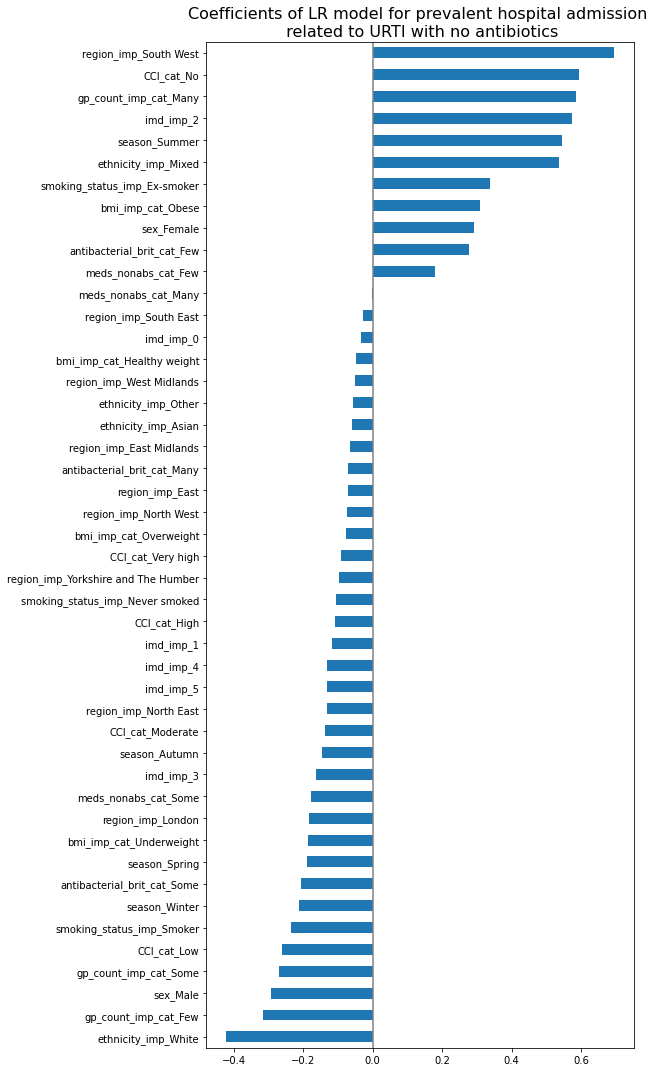

In [243]:
coef_lr.plot(kind="barh", figsize=(9, 15))
plt.title('Coefficients of LR model for prevalent hospital admission \n related to URTI with no antibiotics', fontsize=16)
plt.axvline(x=0, color=".5")
# plt.subplots_adjust(left=0.3)
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/coef_lr_urti_no_abs_prevl.jpg', bbox_inches='tight')
plt.show()


In [244]:
a = lr_urti_no_abs_prevl.intercept_

# save 
np.savetxt('../output/hospitalisation_prediction_urti/intercept_urti_no_abs_prevl.txt', a, delimiter=',')

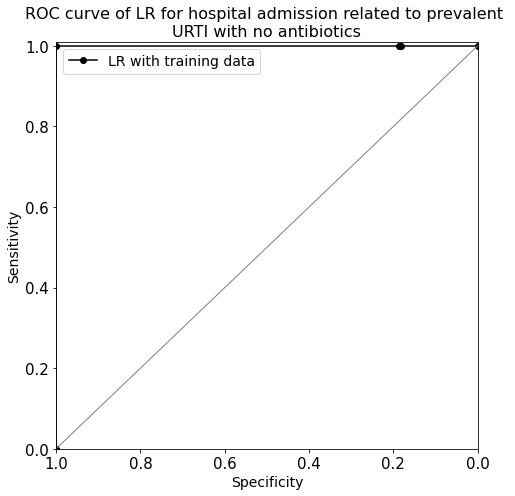

In [246]:
r_fpr1, r_tpr1, _ = roc_curve(data_urti_no_abs_prevl_lr_y_train, pred_proba_urti_no_abs_prevl_train[:,1])
r_fpr2, r_tpr2, _ = roc_curve(data_urti_no_abs_prevl_lr_y_test, pred_proba_urti_no_abs_prevl_test[:,1])

fig, ax1 = pyplot.subplots(figsize=(7, 7))

line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='LR with training data')
line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='LR with testing data')


squares = [0,1]
plt.plot(squares,linewidth=1, color='grey')
plt.ylim(0,1.01)
plt.xlim(0,1)

#plt.title('ROC Curve')
plt.xlabel('Specificity', fontsize=14)
plt.ylabel('Sensitivity', fontsize=14)

#reversing xticks
xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
x = np.arange(len(xticks))
ax1.set(xticklabels=xticks)
ax1.legend(fontsize=14)
plt.title('ROC curve of LR for hospital admission related to prevalent \nURTI with no antibiotics', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15, rotation=0)
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/roc_lr_urti_no_abs_prevl.jpg', bbox_inches='tight')
plt.show()

In [250]:
r_auc1 = roc_auc_score(data_urti_no_abs_prevl_lr_y_train, pred_proba_urti_no_abs_prevl_train[:,1])
r_auc2 = roc_auc_score(data_urti_no_abs_prevl_lr_y_test, pred_proba_urti_no_abs_prevl_test[:,1])
brier1 = brier_score_loss(data_urti_no_abs_prevl_lr_y_train, pred_proba_urti_no_abs_prevl_train[:,1])
brier2 = brier_score_loss(data_urti_no_abs_prevl_lr_y_test, pred_proba_urti_no_abs_prevl_test[:,1])

print('AUROC of LR with training data of hospital admission related to prevalent URTI with no antibiotics = %.4f' % (r_auc1))
print('AUROC of LR with testing data of hospital admission related to prevalent URTI with no antibiotics = %.4f' % (r_auc2))
print('Brier score of LR with training data of hospital admission related to prevalent URTI with no antibiotics = %.4f' % (brier1))
print('Brier score of LR with testing data of hospital admission related to prevalent URTI with no antibiotics = %.4f' % (brier2))

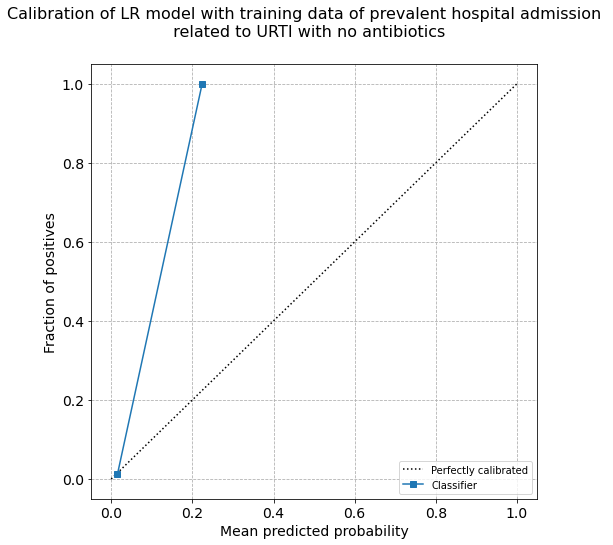

In [251]:
fig, axe = plt.subplots(figsize=(8, 8)
                        )

calib_lr_urti_no_abs_prevl_train = CalibrationDisplay.from_predictions(data_urti_no_abs_prevl_lr_y_train, pred_proba_urti_no_abs_prevl_train[:,1], ax = axe)
plt.suptitle('Calibration of LR model with training data of prevalent hospital admission \n related to URTI with no antibiotics', fontsize=16)
plt.xlabel('Mean predicted probability', fontsize=14)
plt.ylabel('Fraction of positives', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(visible=bool, linestyle='--')
# plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/calib_lr_urti_no_abs_prevl_train.jpg', bbox_inches='tight')
plt.show()

In [ ]:
fig, axe = plt.subplots(figsize=(8, 8)
                        )

calib_lr_urti_no_abs_prevl_train = CalibrationDisplay.from_predictions(data_urti_no_abs_prevl_lr_y_test, pred_proba_urti_no_abs_prevl_test[:,1], ax = axe)
plt.suptitle('Calibration of LR model with testing data of prevalent hospital admission \n related to URTI with no antibiotics', fontsize=16)
plt.xlabel('Mean predicted probability', fontsize=14)
plt.ylabel('Fraction of positives', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(visible=bool, linestyle='--')
# plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/calib_lr_urti_no_abs_prevl_test.jpg', bbox_inches='tight')
plt.show()

In [ ]:
# save model outputs
a = open("../output/hospitalisation_prediction_urti/lr_urti_no_abs_prevl_output.txt", "w")
a.write("")
a.writelines(['AUROC of LR with training data of hospital admission related to prevalent URTI with no antibiotics = %.4f' % (r_auc1),
              '\nAUROC of LR with testing data of hospital admission related to prevalent URTI with no antibiotics = %.4f' % (r_auc2),
              '\nBrier score of LR with training data of hospital admission related to prevalent URTI with no antibiotics = %.4f' % (brier1),
              '\nBrier score of LR with testing data of hospital admission related to prevalent URTI with no antibiotics = %.4f' % (brier2)])